# Repeating Every Experiment & Assessment: 2.5D Version



##### <center> <i> <span style="color:green"> Before we start... </span> </i> </center>

As the title indicates, I'll be exploring results of using 2.5D classification, and comparing them with the replication of slices, in order to ascertain whether this approach is successful. 

Of course, these results will most likely be quite specific to my data set and methodologies, and will only represent a direct comparison and quality of my own methods.

In order to maintain consistent cross-analysis results contrasts, each experiment will retain its original train-test-validation split and ResNet setup (architecture, settings, etc.).

Additionally, I'll be avoiding some experimental comparisons, as they provided results that are guaranteed to be identical throughout both <span style="color:#2377c4"> 2D (represented in blue) </span> and <span style="color:orange"> 2.5D (represented in orange)</span> classification. For example, I will not be using HRCT as the test split, nor testing whether the pure or conservative approach is best for best epoch choice. 

Still, all of this implies several code replications and re-executions. For this reason, I chose to display results in the form of a small report, with indexes and numbered titles, in order to facilitate comprehension and analysis.

---

# Table of Contents

- [1. Data Augmentation vs No Augmentation](#1-data-augmentation-vs-no-augmentation)
  - [1.1 Concept Overview](#11-concept-overview)
  - [1.2 Data Augmentation vs No Augmentation](#13-25d-execution-of-data-augmentation-vs-no-augmentation)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>

  - [1.3 Threshold Selection and Model Choice](#12-threshold-selection-and-model-choice)
  - [1.4 Comparison with 2D](#14-comparison-with-2d)

- [2. Patient-wise Classification Methods](#2-patient-wise-classification-methods)
  - [2.1 Concept Overview](#21-concept-overview)
  - [2.2 Patient-wise Classification Methods](#23-25d-execution-of-patient-wise-classification-methods)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [2.3 Threshold Selection and Model Choice](#22-threshold-selection-and-model-choice)
  - [2.4 Comparison with 2D](#24-comparison-with-2d)

- [3. Slice-level Feature-wise Classification](#3-slice-level-feature-wise-classification)
  - [3.1 Concept Overview](#31-concept-overview)
  - [3.2 Slice-level Feature-wise Classification](#33-25d-execution-of-slice-level-feature-wise-classification)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [3.3 Threshold Selection and Model Choice](#32-threshold-selection-and-model-choice)
  - [3.4 Comparison with 2D](#34-comparison-with-2d)

- [4. Conclusion](#4-conclusion)
  - [4.1 Methodology for Plots](#meth)

<br>

---

<a name="1-data-augmentation-vs-no-augmentation"></a>
## 1. Data Augmentation vs No Augmentation

This section will be dedicated to assess whether the 2.5D model can outperform the 2D model. In order to do so, the first step is to run both resnets with the same configuration, architecture and data split. (only because the original ResNet was only trained for 50 epochs, and is therefore not directly comparable).


<a name="11-concept-overview"></a>
### 1.1 Concept Overview  

For detailed information on augmentations, please refer to directory `3 - resnetTesting`.



<a name="13-25d-execution-of-data-augmentation-vs-no-augmentation"></a>
### 1.2 Data Augmentation vs No Augmentation  


The dictionary below will be used to save relevant metadata and models, with structure:

```py

results_aug["method"] = [best_epoch, train_loss, best_val_loss, model]

```

In [118]:
results_aug = {}

In [119]:
from newDimUtils import *

import matplotlib.colors as mcolors

# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

SliceID  Class
0  101__CT-0002-0001.npy      0
1  101__CT-0002-0002.npy      0
2  101__CT-0002-0003.npy      0
3  101__CT-0002-0004.npy      0
4  101__CT-0002-0005.npy      0

<center> 

#### <span style="color:#2377c4"> 2D, no Augmentations </span>

</center>

In [120]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            # idx represents index
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")
            slice_id = self.img_labels.iloc[idx, 0]
            patient_id = getPatientID(slice_id)

            # Load the .npy file
            image = np.load(img_path)
            
            #image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Already has resize prior to augments
            if self.albumentations:
                stacked_aug = self.albumentations(image=image)
                image = stacked_aug['image']

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)

            
            return image, label, patient_id

In [121]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Needed for classification
test_dataset_2d_noAug = test_dataset
val_dataset_2d_noAug = val_dataset

SliceID at index 165: 121__CT-0844-0020.npy
(224, 224, 3)


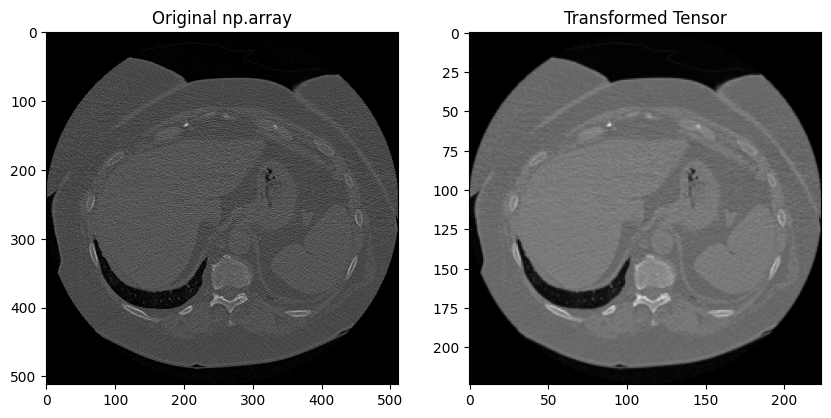

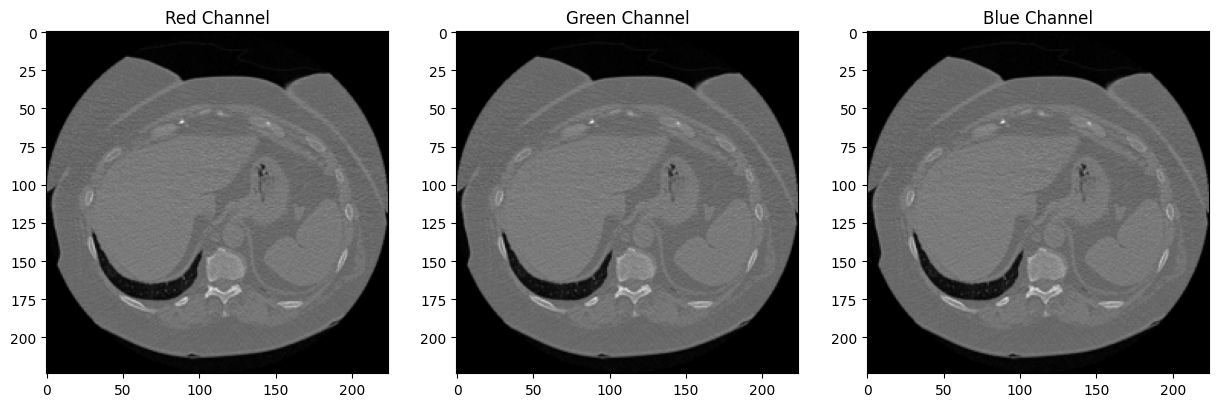

In [122]:
tensorVSnp(train_dataset, df_fibrosis)

In [123]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\2209417091.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_

In [124]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [125]:
# Save to dict for result comparison
results_aug["2d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:#2377c4"> 2D, with Augmentations </span>

</center>

In [126]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for eval

val_dataset_2d_Aug = val_dataset
test_dataset_2d_Aug = train_dataset

SliceID at index 1642: HRCT_Pilot__208__SerieCT-0002-0027.npy
(224, 224, 3)


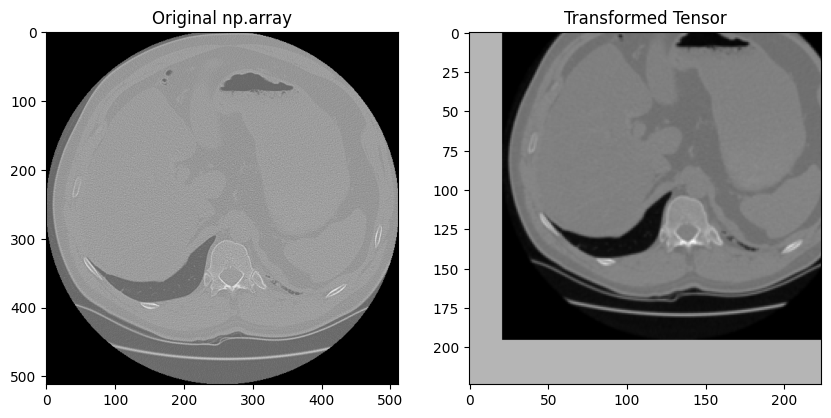

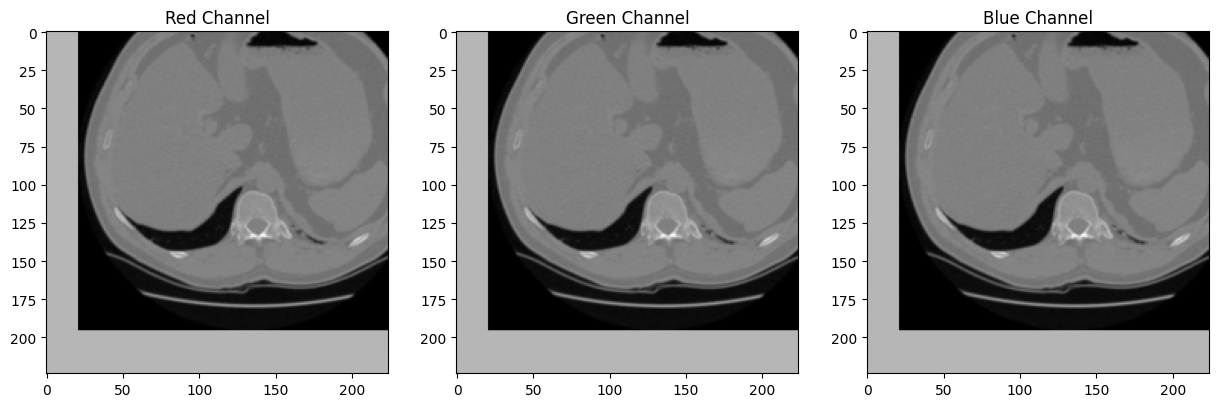

In [136]:
tensorVSnp(train_dataset, df_fibrosis)

In [128]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\2772197137.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_

In [129]:
ans = str(input("Do you wish to save?"))

#ans = "yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [130]:
# Save to dict for result comparison
results_aug["2d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, no Augmentations </span>

</center>

In [155]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label, patient_id

In [156]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for eval 

val_dataset_2_5d_noAug = val_dataset
test_dataset_2_5d_noAug = test_dataset

SliceID at index 619: 163__CT-4728-0005.npy
(224, 224, 3)


C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = os.path.join(self.img_dir, row[0])
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return img, label, row[0]


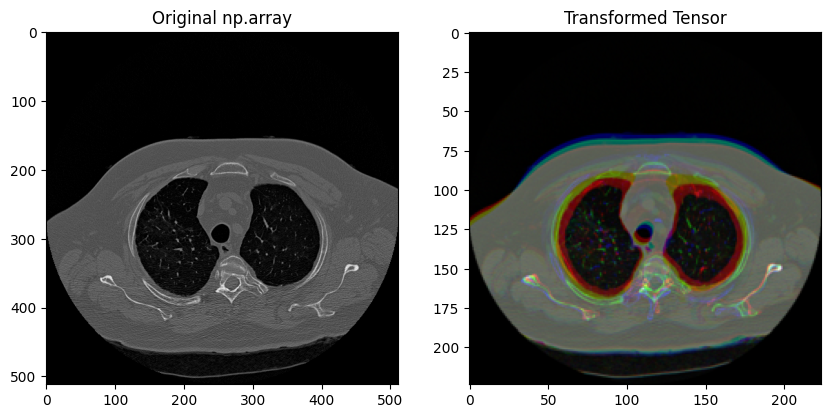

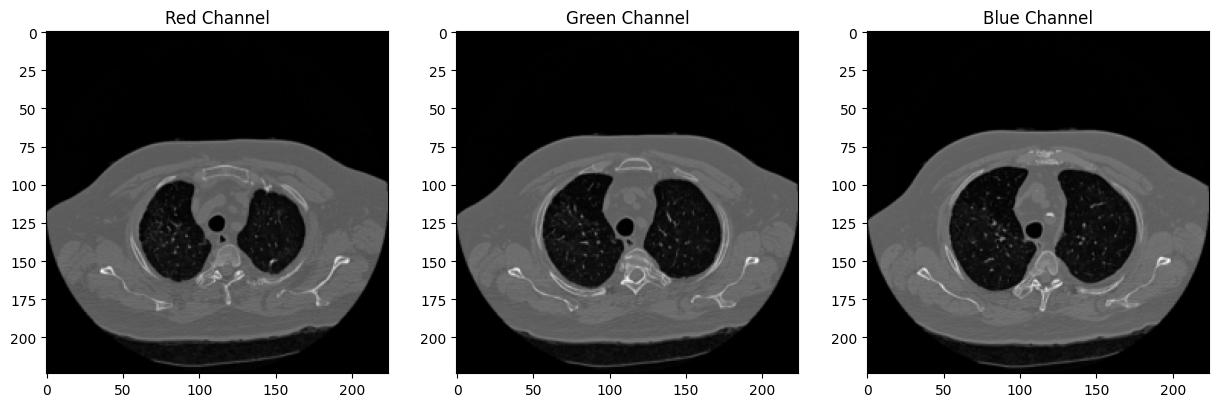

In [157]:
tensorVSnp(train_dataset, df_fibrosis)

In [ ]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2_5d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\492611638.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_N

In [159]:
ans = str(input("Do you wish to save?"))
#ans = "yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2_5d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [143]:
results_aug["2_5d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, with Augmentations </span>

</center>

In [160]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 662: 164__CT-0002-0021.npy
(224, 224, 3)


C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = os.path.join(self.img_dir, row[0])
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return img, label, row[0]


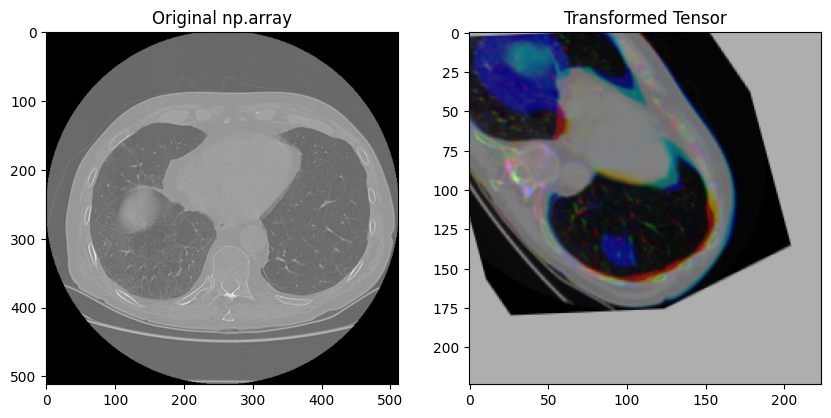

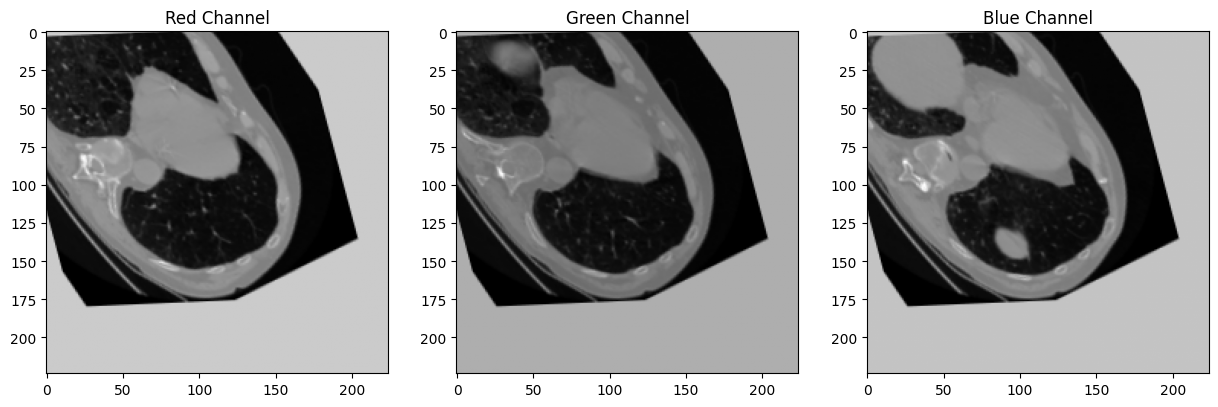

In [162]:
tensorVSnp(train_dataset, df_fibrosis)

In [164]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))
#ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2_5d.pkl"))


else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...:   0%|          | 0/55 [00:00<?, ?it/s]C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = os.path.join(self.img_dir, row[0])
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]
C:\Users\hasht\AppData\Local\Temp\ipykernel_10652\448409968.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

Epoch [1/90], Train loss: 0.801049
Validation loss: 0.795242


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [2/90], Train loss: 0.779042
Validation loss: 0.783290


Training...: 100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


Epoch [3/90], Train loss: 0.766101
Validation loss: 0.771095


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [4/90], Train loss: 0.743006
Validation loss: 0.759402


Training...: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


Epoch [5/90], Train loss: 0.728655
Validation loss: 0.749209


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [6/90], Train loss: 0.716800
Validation loss: 0.739007


Training...: 100%|██████████| 55/55 [01:07<00:00,  1.22s/it]


Epoch [7/90], Train loss: 0.705523
Validation loss: 0.728332


Training...: 100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


Epoch [8/90], Train loss: 0.689271
Validation loss: 0.718159


Training...: 100%|██████████| 55/55 [01:12<00:00,  1.32s/it]


Epoch [9/90], Train loss: 0.674604
Validation loss: 0.708127


Training...: 100%|██████████| 55/55 [01:11<00:00,  1.29s/it]


Epoch [10/90], Train loss: 0.656490
Validation loss: 0.698340


Training...: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Epoch [11/90], Train loss: 0.647781
Validation loss: 0.689756


Training...: 100%|██████████| 55/55 [01:12<00:00,  1.32s/it]


Epoch [12/90], Train loss: 0.637301
Validation loss: 0.680692


Training...: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Epoch [13/90], Train loss: 0.619949
Validation loss: 0.671879


Training...: 100%|██████████| 55/55 [01:11<00:00,  1.30s/it]


Epoch [14/90], Train loss: 0.611604
Validation loss: 0.663435


Training...: 100%|██████████| 55/55 [01:12<00:00,  1.32s/it]


Epoch [15/90], Train loss: 0.602929
Validation loss: 0.655065


Training...: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


Epoch [16/90], Train loss: 0.592279
Validation loss: 0.646968


Training...: 100%|██████████| 55/55 [01:12<00:00,  1.31s/it]


Epoch [17/90], Train loss: 0.579223
Validation loss: 0.639200


Training...: 100%|██████████| 55/55 [01:17<00:00,  1.41s/it]


Epoch [18/90], Train loss: 0.568073
Validation loss: 0.631898


Training...: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Epoch [19/90], Train loss: 0.560717
Validation loss: 0.624670


Training...: 100%|██████████| 55/55 [01:23<00:00,  1.52s/it]


Epoch [20/90], Train loss: 0.549291
Validation loss: 0.617473


Training...: 100%|██████████| 55/55 [01:34<00:00,  1.72s/it]


Epoch [21/90], Train loss: 0.542257
Validation loss: 0.610432


Training...: 100%|██████████| 55/55 [01:33<00:00,  1.70s/it]


Epoch [22/90], Train loss: 0.531918
Validation loss: 0.604053


Training...: 100%|██████████| 55/55 [01:30<00:00,  1.64s/it]


Epoch [23/90], Train loss: 0.535451
Validation loss: 0.597321


Training...: 100%|██████████| 55/55 [07:44<00:00,  8.44s/it]


Epoch [24/90], Train loss: 0.517393
Validation loss: 0.591130


Training...: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Epoch [25/90], Train loss: 0.508896
Validation loss: 0.585966


Training...: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Epoch [26/90], Train loss: 0.499548
Validation loss: 0.579804


Training...: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


Epoch [27/90], Train loss: 0.491091
Validation loss: 0.574156


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [28/90], Train loss: 0.486286
Validation loss: 0.568705


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it]


Epoch [29/90], Train loss: 0.475438
Validation loss: 0.563234


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [30/90], Train loss: 0.471333
Validation loss: 0.557694


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [31/90], Train loss: 0.462909
Validation loss: 0.552472


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it]


Epoch [32/90], Train loss: 0.459818
Validation loss: 0.547159


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.37s/it]


Epoch [33/90], Train loss: 0.452390
Validation loss: 0.541968


Training...: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it]


Epoch [34/90], Train loss: 0.444802
Validation loss: 0.537237


Training...: 100%|██████████| 55/55 [01:16<00:00,  1.39s/it]


Epoch [35/90], Train loss: 0.440437
Validation loss: 0.532602


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [36/90], Train loss: 0.437953
Validation loss: 0.528040


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [37/90], Train loss: 0.438355
Validation loss: 0.523513


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [38/90], Train loss: 0.417762
Validation loss: 0.518481


Training...: 100%|██████████| 55/55 [01:15<00:00,  1.38s/it]


Epoch [39/90], Train loss: 0.417417
Validation loss: 0.515152


Training...: 100%|██████████| 55/55 [01:14<00:00,  1.35s/it]


Epoch [40/90], Train loss: 0.415622
Validation loss: 0.511369


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.27s/it]


Epoch [41/90], Train loss: 0.402851
Validation loss: 0.507038


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [42/90], Train loss: 0.399214
Validation loss: 0.503392


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.27s/it]


Epoch [43/90], Train loss: 0.394923
Validation loss: 0.500444


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [44/90], Train loss: 0.391348
Validation loss: 0.496817


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [45/90], Train loss: 0.381023
Validation loss: 0.493285


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [46/90], Train loss: 0.382633
Validation loss: 0.490110


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [47/90], Train loss: 0.374854
Validation loss: 0.486820


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [48/90], Train loss: 0.376808
Validation loss: 0.484010


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.29s/it]


Epoch [49/90], Train loss: 0.365875
Validation loss: 0.481043


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [50/90], Train loss: 0.362279
Validation loss: 0.478408


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [51/90], Train loss: 0.375828
Validation loss: 0.475844


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [52/90], Train loss: 0.354975
Validation loss: 0.473539


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [53/90], Train loss: 0.361908
Validation loss: 0.470966


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [54/90], Train loss: 0.346702
Validation loss: 0.468814


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [55/90], Train loss: 0.345032
Validation loss: 0.466111


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [56/90], Train loss: 0.350159
Validation loss: 0.463621


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [57/90], Train loss: 0.337921
Validation loss: 0.461477


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [58/90], Train loss: 0.334766
Validation loss: 0.459153


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.25s/it]


Epoch [59/90], Train loss: 0.336988
Validation loss: 0.456865


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [60/90], Train loss: 0.336094
Validation loss: 0.455261


Training...: 100%|██████████| 55/55 [01:11<00:00,  1.30s/it]


Epoch [61/90], Train loss: 0.325744
Validation loss: 0.453832


Training...: 100%|██████████| 55/55 [01:11<00:00,  1.29s/it]


Epoch [62/90], Train loss: 0.325228
Validation loss: 0.451609


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [63/90], Train loss: 0.315403
Validation loss: 0.449675


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [64/90], Train loss: 0.316321
Validation loss: 0.447594


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [65/90], Train loss: 0.309020
Validation loss: 0.445892


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [66/90], Train loss: 0.316067
Validation loss: 0.444042


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [67/90], Train loss: 0.310904
Validation loss: 0.442587


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Epoch [68/90], Train loss: 0.306033
Validation loss: 0.440911


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [69/90], Train loss: 0.311665
Validation loss: 0.439427


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch [70/90], Train loss: 0.301521
Validation loss: 0.438306


Training...: 100%|██████████| 55/55 [01:10<00:00,  1.27s/it]


Epoch [71/90], Train loss: 0.297052
Validation loss: 0.436320


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [72/90], Train loss: 0.294704
Validation loss: 0.435020


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [73/90], Train loss: 0.288372
Validation loss: 0.433499


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [74/90], Train loss: 0.301980
Validation loss: 0.431882


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Epoch [75/90], Train loss: 0.286513
Validation loss: 0.430911


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Epoch [76/90], Train loss: 0.280400
Validation loss: 0.429454


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [77/90], Train loss: 0.281382
Validation loss: 0.428465


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [78/90], Train loss: 0.280324
Validation loss: 0.426935


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [79/90], Train loss: 0.284279
Validation loss: 0.425664


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [80/90], Train loss: 0.276212
Validation loss: 0.424657


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [81/90], Train loss: 0.274597
Validation loss: 0.423639


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [82/90], Train loss: 0.274973
Validation loss: 0.423217


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [83/90], Train loss: 0.273566
Validation loss: 0.422132


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [84/90], Train loss: 0.268884
Validation loss: 0.421945


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [85/90], Train loss: 0.268026
Validation loss: 0.420738


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [86/90], Train loss: 0.276912
Validation loss: 0.419362


Training...: 100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch [87/90], Train loss: 0.267802
Validation loss: 0.418884


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Epoch [88/90], Train loss: 0.265237
Validation loss: 0.418049


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [89/90], Train loss: 0.270694
Validation loss: 0.417361


Training...: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Epoch [90/90], Train loss: 0.271621
Validation loss: 0.417229


In [165]:
#ans = str(input("Do you wish to save?"))
ans="yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2_5d.pkl"))

else: print("DID NOT SAVE")

In [166]:
# Save to dict for result comparison
results_aug["2_5d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<a name="12-threshold-selection-and-model-choice"></a>
### 1.3 Threshold Selection and Model Choice  



In [184]:
def getAllROCs(results_dict, val_dataset, validation=True):
    threshold_dict = {}
    all_rocs = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    subplot_positions = {}

    for key in results_dict:
        # Determine row
        if "2_5" in key:
            row = 1  
            if not validation and "no" in key: val_dataset = test_dataset_2_5d_noAug
            if not validation and not ("no" in key): val_dataset = test_dataset
        else: 
            row = 0
            if validation: val_dataset = val_dataset_2d_noAug
            elif "no" in key: val_dataset = test_dataset_2d_noAug
            else: val_dataset = test_dataset_2d_Aug
        # Determine column
        col = 0 if ("no" in key or "No" in key) else 1
        subplot_positions[key] = (row, col)
    
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        for key, value in tqdm(results_dict.items()):
            model = value[3]
            model.to(device)
            model.eval()

            all_labels, all_scores = [], []

            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    probs = F.softmax(outputs, dim=1)[:, 1]

                    all_scores.extend(probs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        distances = np.sqrt((fpr) ** 2 + (1 - tpr) ** 2)
        best_idx = np.argmin(distances)
        best_threshold = thresholds[best_idx]

        threshold_dict[key] = best_threshold
        all_rocs[key] = (fpr, tpr, roc_auc, best_threshold, best_idx)

        # Subplot position
        row, col = subplot_positions[key]
        ax = axs[row][col]

        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Threshold = {best_threshold:.2f}')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(key)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Combined plot
    plt.figure(figsize=(8, 6))
    for key, (fpr, tpr, roc_auc, best_threshold, best_idx) in all_rocs.items():
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return threshold_dict


In [185]:
def darken_color(color, factor=0.7):
    """Darken a color by a given factor (0 to 1)."""
    rgb = mcolors.to_rgb(color)
    return tuple(np.clip([c * factor for c in rgb], 0, 1))

def plotAllLossCurves(results_dict):
    num_models = len(results_dict)
    plt.figure(figsize=(12, 10))

    # Individual subplots (2 rows × 2 cols)
    for idx, (key, values) in enumerate(results_dict.items()):
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        plt.subplot(2, 2, idx + 1)
        plt.plot(epochs, train_loss, label='Train Loss', linestyle='-', marker='o')
        plt.plot(epochs, val_loss, label='Val Loss', linestyle='--', marker='x')
        plt.plot(best_epoch, best_val_loss, 'X', color='purple', markersize=10, label='Best Epoch')

        plt.title(key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- Combined Plot -----
    plt.figure(figsize=(10, 6))

    # Use a predefined color cycle (can also use seaborn or matplotlib colormaps)
    color_cycle = plt.cm.tab10.colors  # 10 distinct colors
    keys = list(results_dict.keys())
    color_map = {key: color_cycle[i % len(color_cycle)] for i, key in enumerate(keys)}

    for key in keys:
        values = results_dict[key]
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        base_color = color_map[key]
        darker_color = darken_color(base_color)

        # Plot both curves in the same color
        plt.plot(epochs, train_loss, color=base_color, linestyle='-', alpha=0.6)
        plt.plot(epochs, val_loss, color=base_color, linestyle='--', alpha=0.9)

        # Plot the 'best epoch' as a darker marker
        plt.plot(best_epoch, best_val_loss, 'X', color=darker_color, markersize=10)

    # Add single legend entry per method
    for key in keys:
        plt.plot([], [], color=color_map[key], label=key)

    plt.title('All Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


<center>

#### Validation ROC

</center>

In [187]:
def getROC(model, val_dataset, method_name): 

    all_labels, all_scores = [], []
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patientID in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Translate logits to Class 1 probabilities using softmax
            # (pulls column 1 values and assigns probabilities)
            probs = F.softmax(outputs, dim=1)[:, 1]  

            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]


    # ---------- Display and Results ---------- 

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print("Area Under Curve:", roc_auc)
    print("Best Threshold (closest to (0,1)):", best_threshold)

    return {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "thresholds": thresholds,
    "best_threshold": best_threshold,
    "best_idx": best_idx,
    "method_name": method_name  
    }

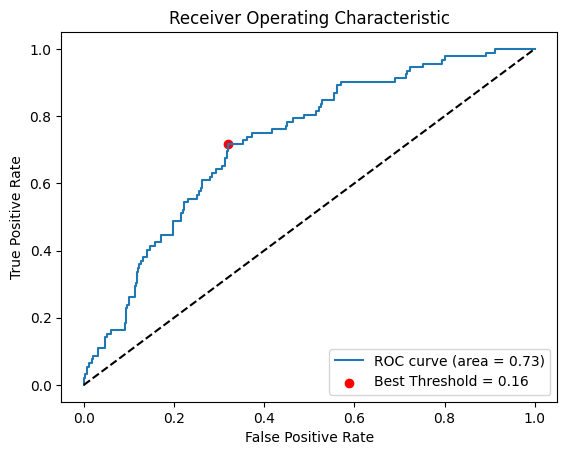

Area Under Curve: 0.7261767876392382
Best Threshold (closest to (0,1)): 0.15959369


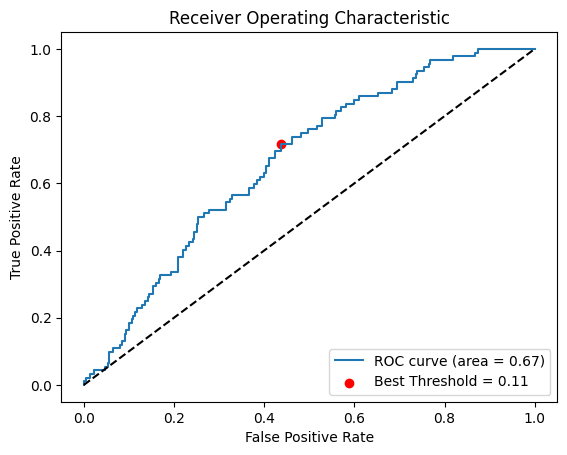

Area Under Curve: 0.6664750269493354
Best Threshold (closest to (0,1)): 0.11265797


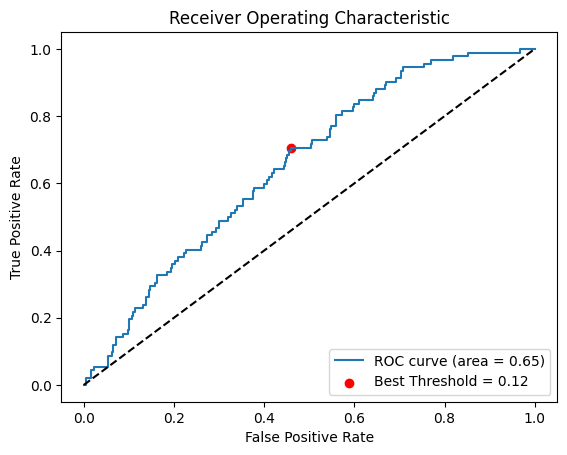

Area Under Curve: 0.654599353215954
Best Threshold (closest to (0,1)): 0.118744634


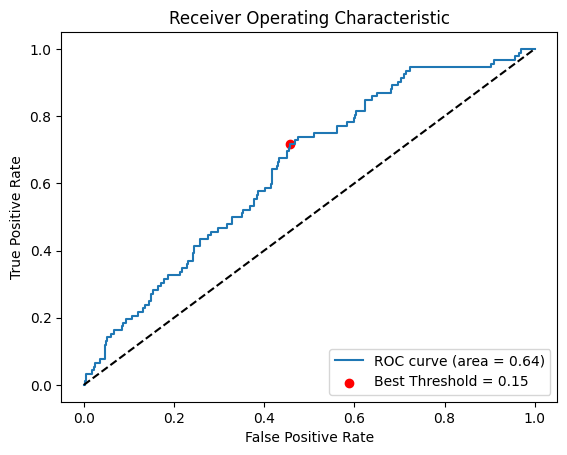

Area Under Curve: 0.6443226733740568
Best Threshold (closest to (0,1)): 0.1540813


In [ ]:
warnings.filterwarnings("ignore")

val_roc_results_aug = {}

# Getting each individual result
# 2D
val_roc_results_aug["2d_noAug"] = getROC(results_aug["2d_noAug"][3], val_dataset_2d_noAug, "2d_noAug")
val_roc_results_aug["2d_Aug"] = getROC(results_aug["2d_Aug"][3], val_dataset_2d_Aug, "2d_Aug")
# 2.5D
val_roc_results_aug["2_5d_noAug"] = getROC(results_aug["2_5d_noAug"][3], val_dataset_2_5d_noAug, "2_5d_noAug")
val_roc_results_aug["2_5d_Aug"] = getROC(results_aug["2_5d_Aug"][3], val_dataset, "2_5d_Aug")

In [327]:
def plotCombinedRoc(roc_dict): 
    plt.figure(figsize=(8, 6))
    for label, result in roc_dict.items():
        plt.plot(result["fpr"], result["tpr"], label=f'{label} (AUC = {result["auc"]:.2f})')
        plt.scatter(result["fpr"][result["best_idx"]], result["tpr"][result["best_idx"]], color='red', s=20)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

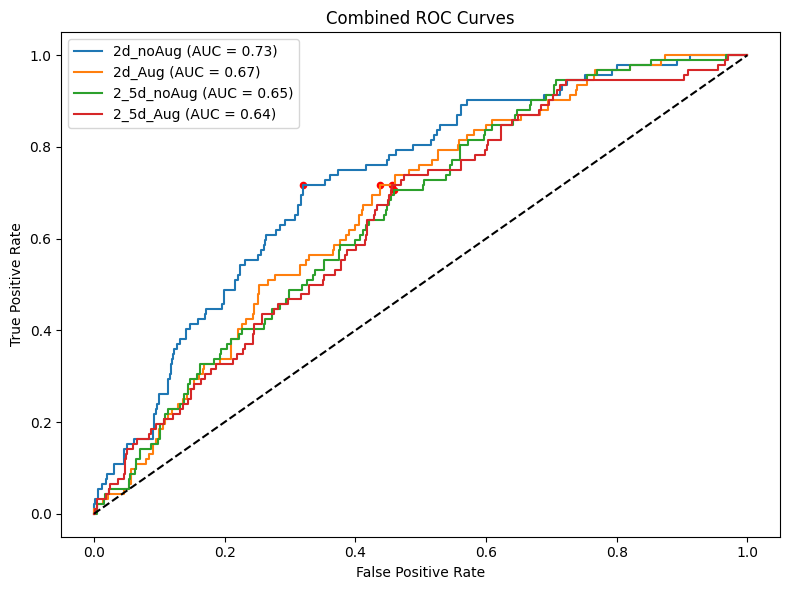

In [328]:
plotCombinedRoc(val_roc_results_aug)

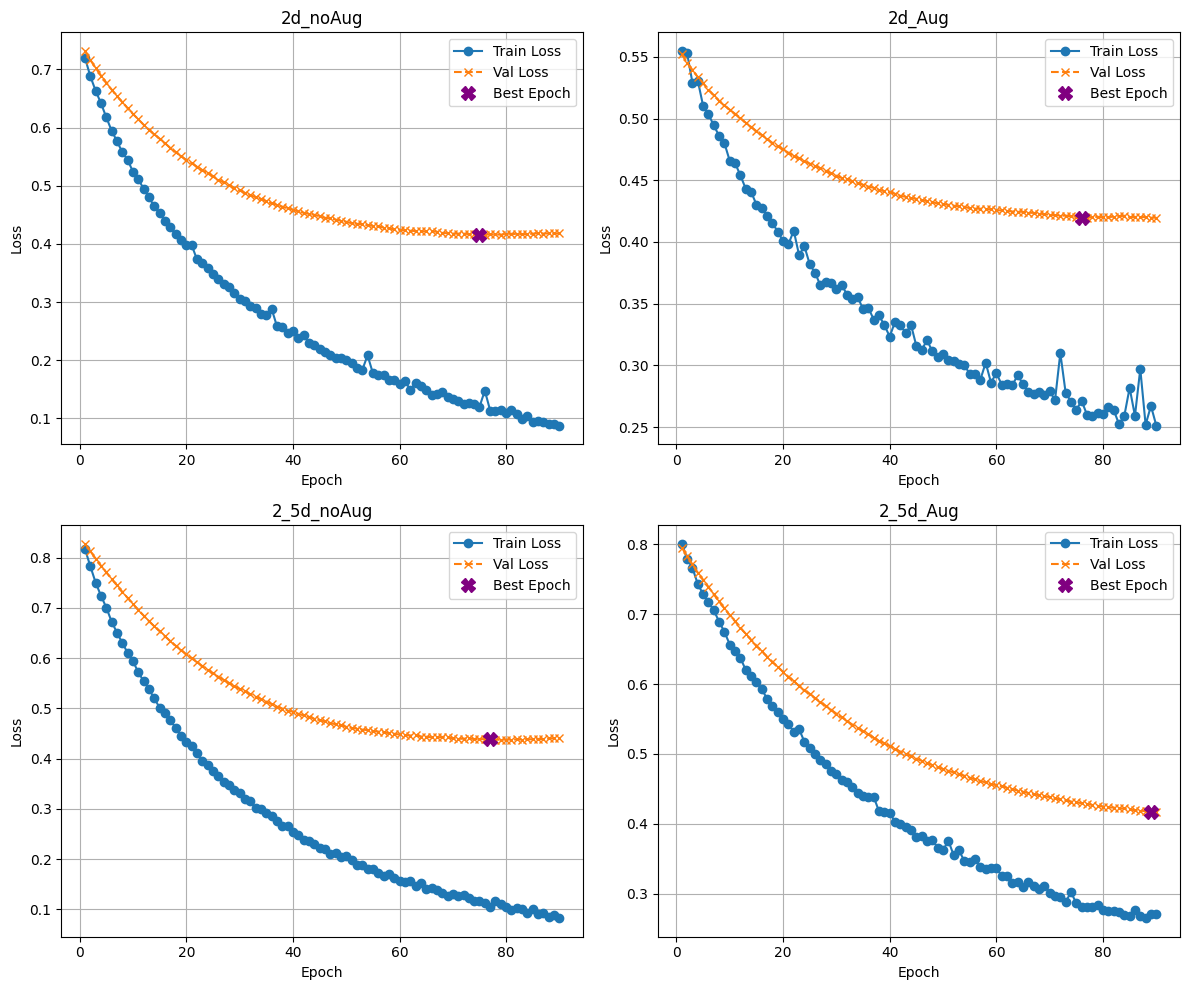

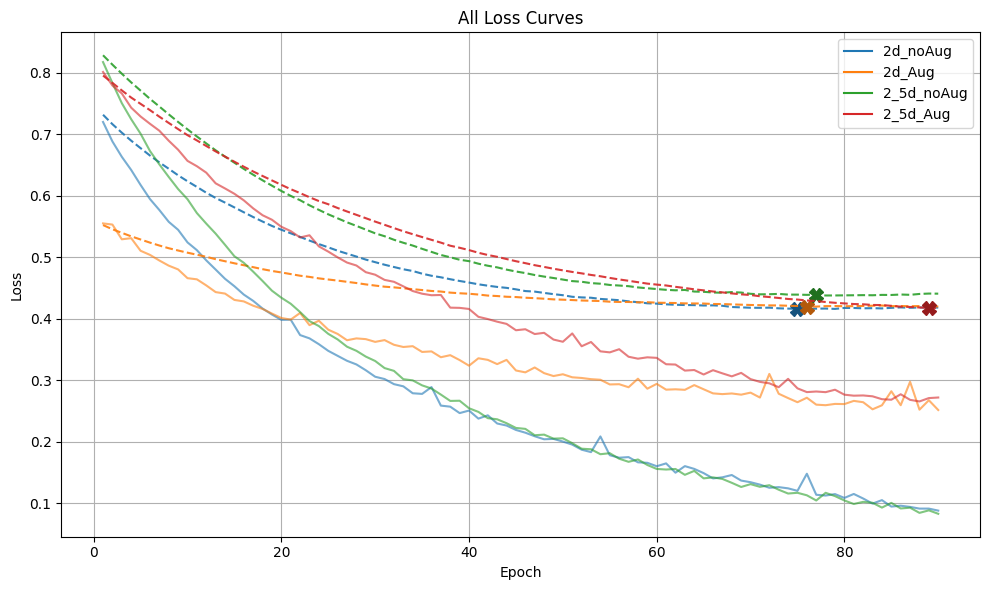

In [191]:
plotAllLossCurves(results_aug)


<a name="14-comparison-with-2d"></a>
### 1.4 Comparison with 2D  

In [192]:
metrics_aug = {}

for key, val in results_aug.items():
    print(f"               Method: {key}\n")
    best_thresh = val_roc_results_aug[key]["best_threshold"]
    if "_5" in key:
        if "no" in key: m_aug = evalResNet(val[3], test_dataset_2_5d_noAug, threshold=best_thresh) # 2.5D, no Aug
        else: m_aug = evalResNet(val[3], test_dataset, threshold=best_thresh) # 2.5D, with Aug
    else: 
        if "no" in key: m_aug = evalResNet(val[3], test_dataset_2d_noAug, threshold=best_thresh) # 2D, no Aug
        else: m_aug = evalResNet(val[3], test_dataset_2d_Aug, threshold=best_thresh) # 2D, with Aug
    metrics_aug[key] = m_aug
    print(" --------------------- \n")

               Method: 2d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 53.64%  (302 in 563)
Accuracy for Class 1: 85.88%  (73 in 85)
Test Accuracy: 57.87%
Weighted Accuracy: 81.59%

 --------------------- 

F1 Score (Macro): 0.519
F1 Score (Weighted): 0.644
F1 Score Class 0: 0.689
F1 Score Class 1: 0.348

 --------------------- 


Confusion Matrix: 
 [[302 261]
 [ 12  73]]
 --------------------- 

               Method: 2d_Aug

Total examples: 1730

 --------------------- 

Accuracy for Class 0: 66.36%  (994 in 1498)
Accuracy for Class 1: 93.53%  (217 in 232)
Test Accuracy: 70.00%
Weighted Accuracy: 89.92%

 --------------------- 

F1 Score (Macro): 0.624
F1 Score (Weighted): 0.748
F1 Score Class 0: 0.793
F1 Score Class 1: 0.455

 --------------------- 


Confusion Matrix: 
 [[994 504]
 [ 15 217]]
 --------------------- 

               Method: 2_5d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 54.71%  (308 in 563)
Accuracy for

<center>

#### Test ROC

</center>

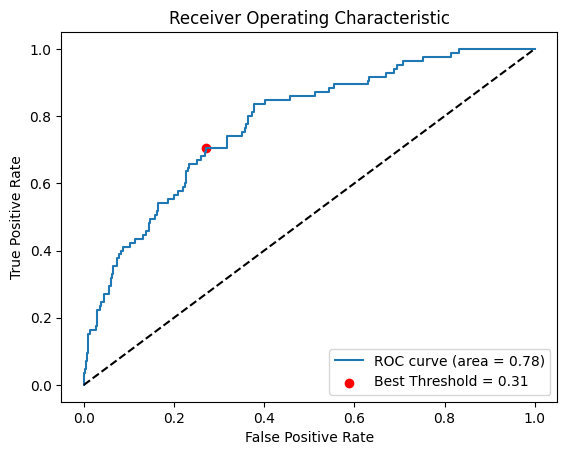

Area Under Curve: 0.779019956117438
Best Threshold (closest to (0,1)): 0.31020853


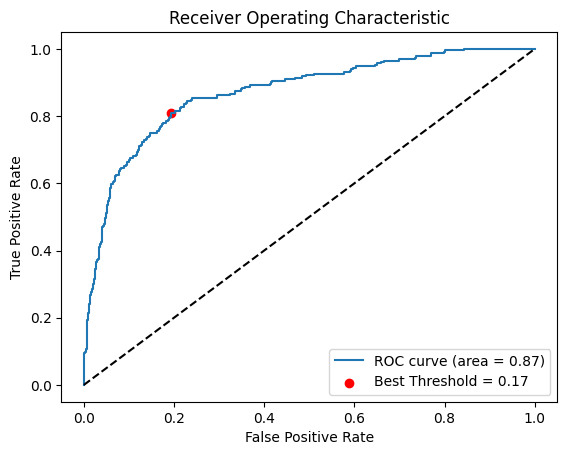

Area Under Curve: 0.8700163436305879
Best Threshold (closest to (0,1)): 0.17026521


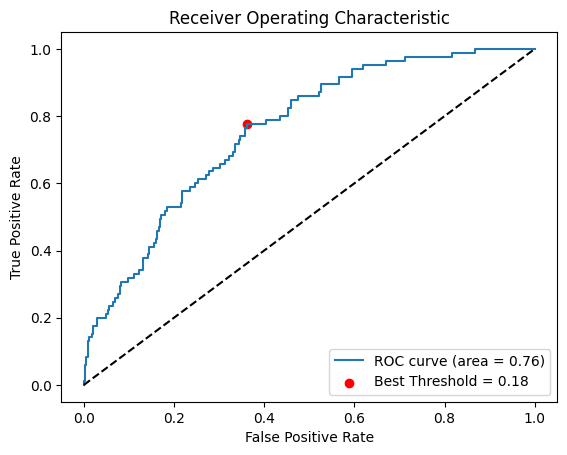

Area Under Curve: 0.7587294953505381
Best Threshold (closest to (0,1)): 0.18300822


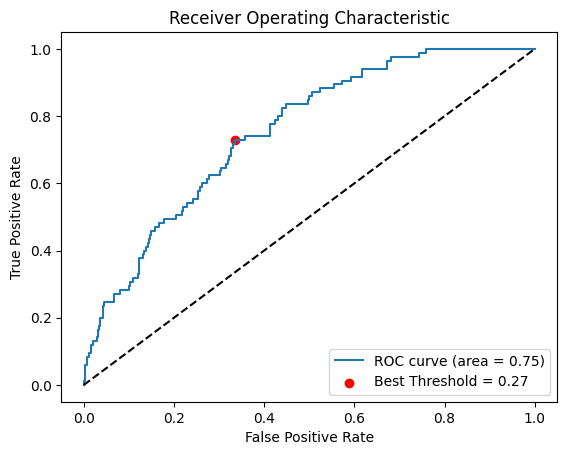

Area Under Curve: 0.7535680702120992
Best Threshold (closest to (0,1)): 0.26728654


In [193]:
warnings.filterwarnings("ignore")

test_roc_results_aug = {}

# Getting each individual result
# 2D
test_roc_results_aug["2d_noAug"] = getROC(results_aug["2d_noAug"][3], test_dataset_2d_noAug, "2d_noAug")
test_roc_results_aug["2d_Aug"] = getROC(results_aug["2d_Aug"][3], test_dataset_2d_Aug, "2d_Aug")
# 2.5D
test_roc_results_aug["2_5d_noAug"] = getROC(results_aug["2_5d_noAug"][3], test_dataset_2_5d_noAug, "2_5d_noAug")
test_roc_results_aug["2_5d_Aug"] = getROC(results_aug["2_5d_Aug"][3], test_dataset, "2_5d_Aug")

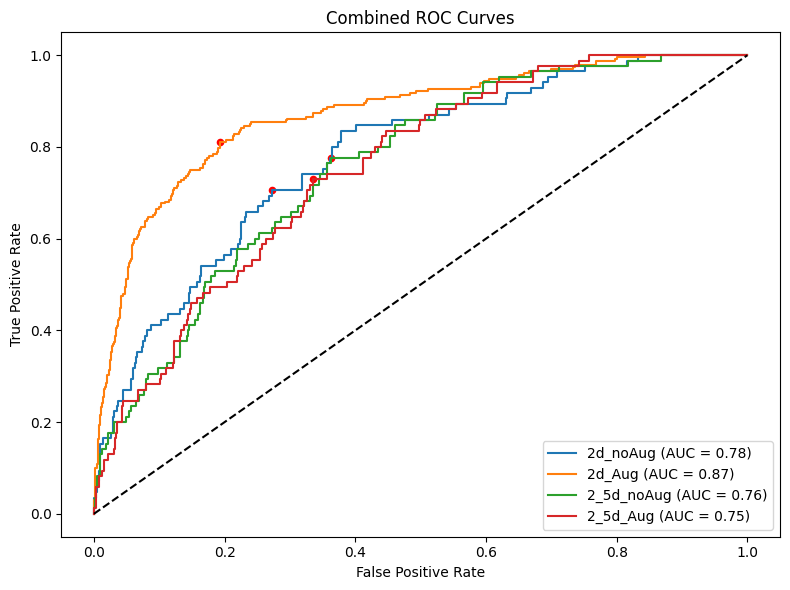

In [329]:
plotCombinedRoc(test_roc_results_aug)

---

<a name="2-patient-wise-classification-methods"></a>

## 2. Patient-wise Classification Methods




<a name="21-concept-overview"></a>
### 2.1 Concept Overview  

For detailed information on patient aggregation methods, please refer to directory `4.2 - evalAsPatient`.




<a name="23-25d-execution-of-patient-wise-classification-methods"></a>
### 2.2 Patient-wise Classification Methods  



In [291]:
results_patient = {}
THRESHOLD_EVAL = 0.26189378

<center> 

#### <span style="color:#2377c4"> 2D, Patient-Wise </span>

</center>

In [309]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)

        return image, label, patient_id

In [310]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for classification

test_dataset_patient = test_dataset
val_dataset_patient = val_dataset

SliceID at index 1119: 62__CT-0002-0019.npy
(224, 224, 3)


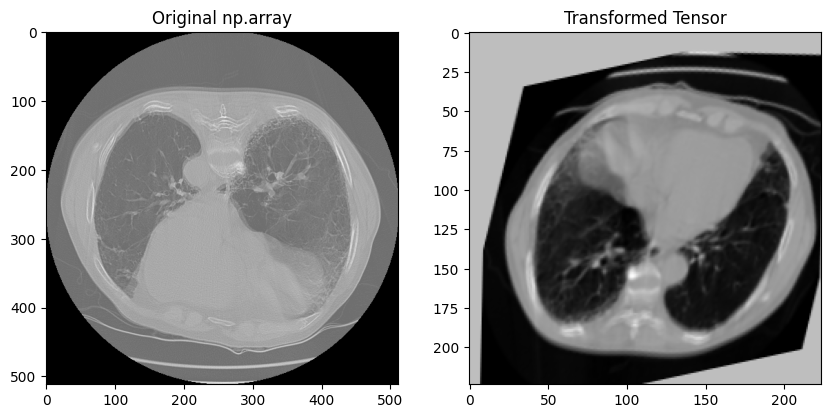

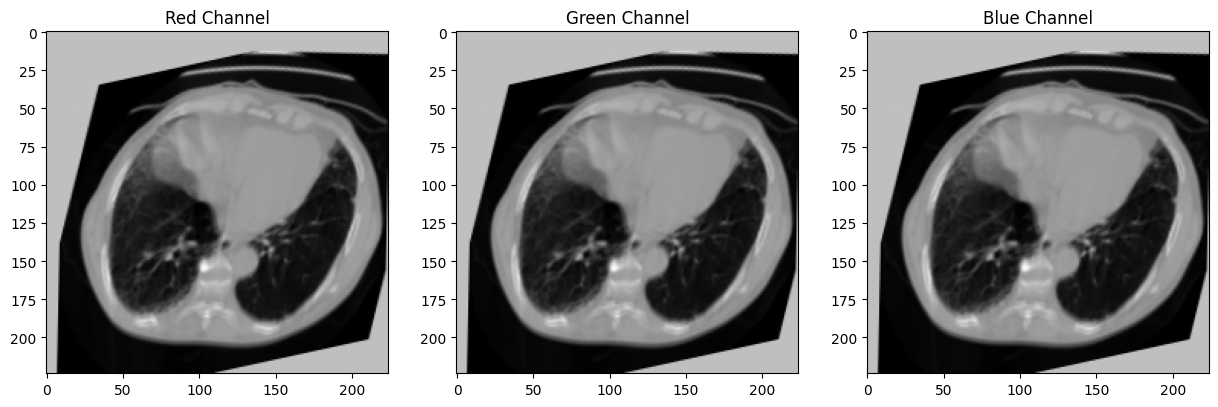

In [311]:
tensorVSnp(train_dataset, df_fibrosis)

In [312]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"


# Read file
checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

# Load values
best_epoch = checkpoint["epoch"]
custom_loss = checkpoint["train_loss"]
custom_val_loss = checkpoint["val_loss"]

resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val.pkl"))

In [313]:
results_patient["2d"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

In [314]:
def getROCAggregate(model, dataset, threshold, aggregate_criteria="mean", show_plot=True, method="2d_"): 

    all_labels, all_scores = [], []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    model.eval()
    with torch.no_grad():
        for images, labels, patient_id in loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = model(images)

            # Translate logits to probabilities using softmax
            # and then chooses only values for Class 1 (0 or 1)
            probs = F.softmax(outputs, dim=1)[:, 1] 
        
            # Associate probabilities/values to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Sets classification as 0 until otherwise

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 # Updates Classification
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            final_prob = np.mean(prob_list)
        
        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            final_prob = (ctr1/(ctr1+ctr0)) if aggregate_criteria == "ratio" else ctr1

        label = patient_class[id]

        #  y_true, y_pred -> all_scores, all_labels
        all_labels.append(label)
        all_scores.append(final_prob)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    if show_plot:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold for method {aggregate_criteria} = {best_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print("Area Under Curve:", roc_auc)
        print("Best Threshold (closest to (0,1)):", best_threshold)

    return {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "thresholds": thresholds,
    "best_threshold": best_threshold,
    "best_idx": best_idx,
    "method_name": method+aggregate_criteria  
    }

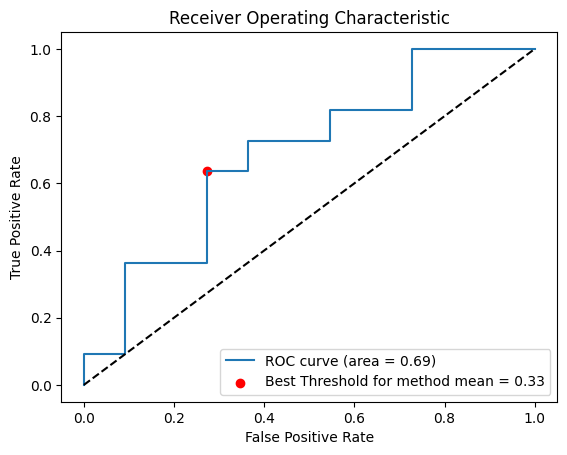

Area Under Curve: 0.6859504132231404
Best Threshold (closest to (0,1)): 0.32591142734655965


In [315]:
warnings.filterwarnings("ignore")

val_roc_results_aggregate = {}

# Getting each individual result
# 2D
val_roc_results_aggregate["2d_mean"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="mean")

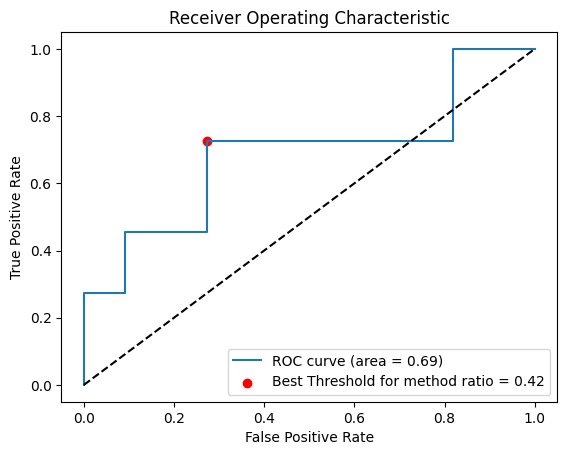

Area Under Curve: 0.6859504132231405
Best Threshold (closest to (0,1)): 0.4166666666666667


In [316]:
val_roc_results_aggregate["2d_ratio"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="ratio")

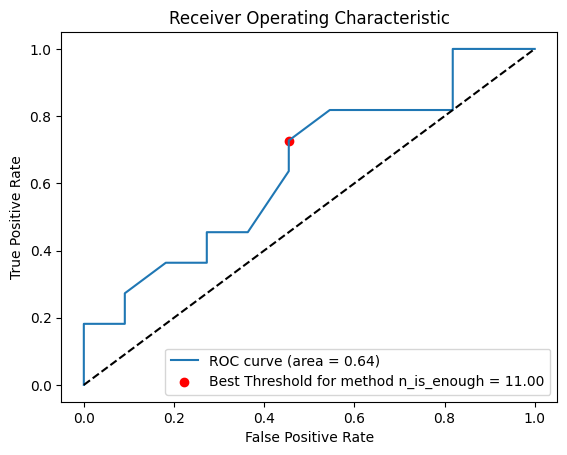

Area Under Curve: 0.6446280991735538
Best Threshold (closest to (0,1)): 11.0


In [317]:
val_roc_results_aggregate["2d_n"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

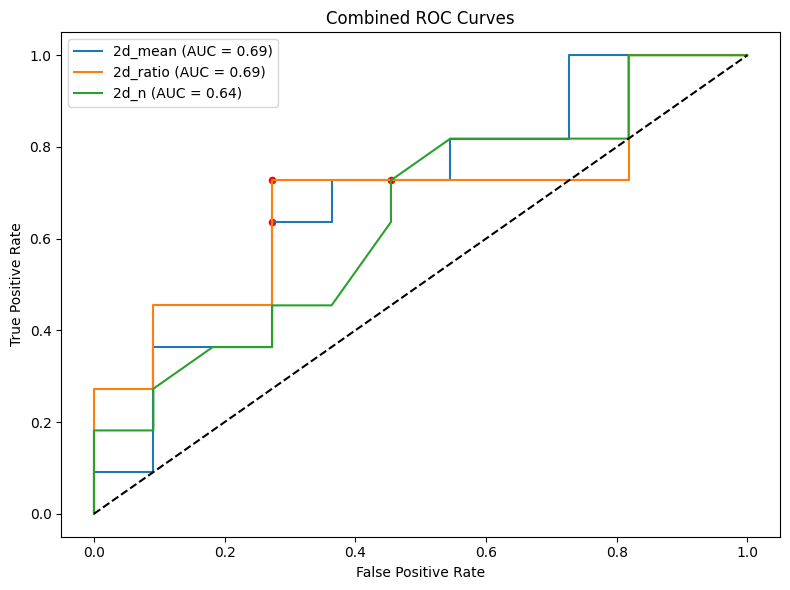

In [318]:
plt.figure(figsize=(8, 6))
for label, result in val_roc_results_aggregate.items():
    plt.plot(result["fpr"], result["tpr"], label=f'{label} (AUC = {result["auc"]:.2f})')
    plt.scatter(result["fpr"][result["best_idx"]], result["tpr"][result["best_idx"]], color='red', s=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [344]:
# Structure is mean, n_is_enough and ratio
thresholds_patient = {}
thresholds_patient["2d"] = [val_roc_results_aggregate["2d_mean"]["best_threshold"],
                             val_roc_results_aggregate["2d_n"]["best_threshold"],
                               val_roc_results_aggregate["2d_ratio"]["best_threshold"],]

<center> 

#### <span style="color:orange"> 2.5D, Patient-Wise </span>

</center>

In [319]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label, patient_id

In [320]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 331: 132__CT-6097-0007.npy
(224, 224, 3)


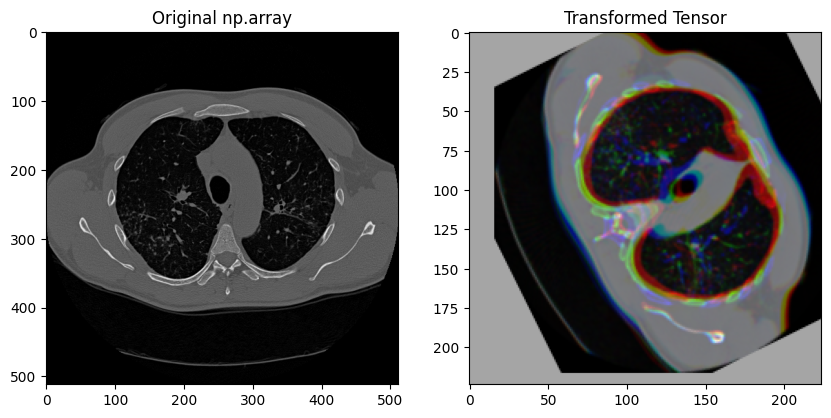

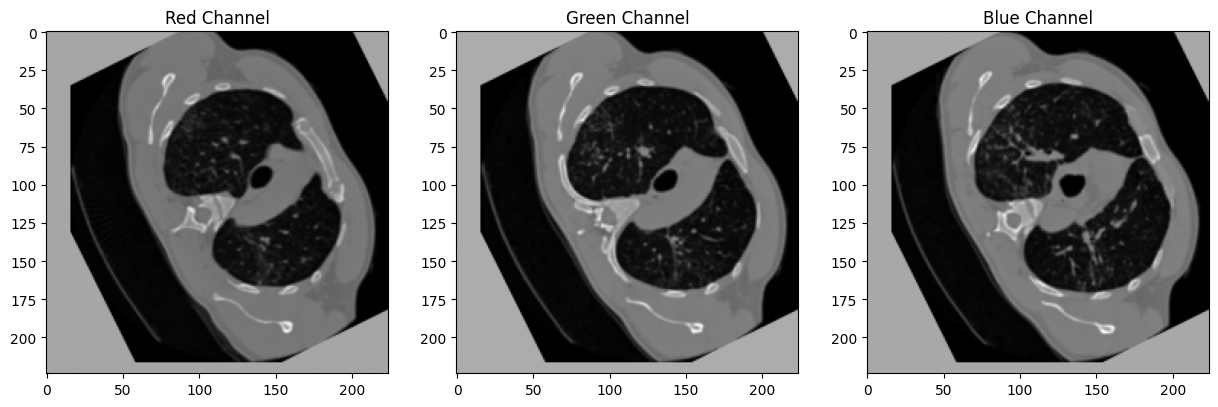

In [321]:
tensorVSnp(train_dataset, df_fibrosis)

No need to run model again. I'll simply be using the 2.5D Augmentation model.

In [322]:
results_patient["2_5d"] = results_aug["2_5d_Aug"]



<a name="22-threshold-selection-and-model-choice"></a>
### 2.3 Threshold Selection and Model Choice  



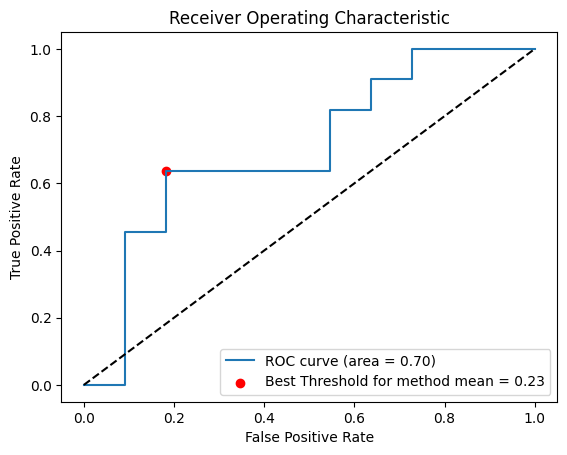

Area Under Curve: 0.7024793388429752
Best Threshold (closest to (0,1)): 0.23276983962758727


In [355]:
warnings.filterwarnings("ignore")

# Getting each individual result
# 2_5d
val_roc_results_aggregate["2_5d_mean"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="mean")

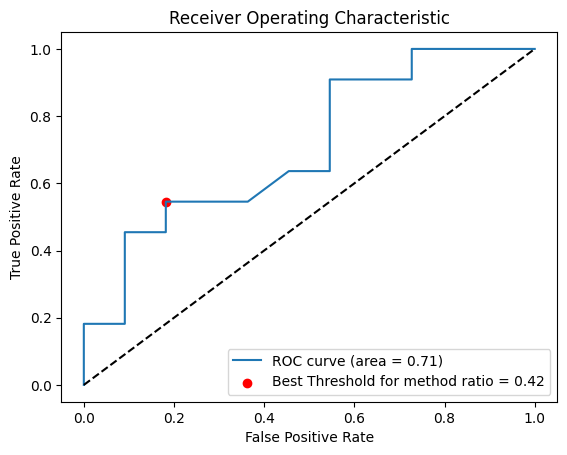

Area Under Curve: 0.7066115702479339
Best Threshold (closest to (0,1)): 0.4230769230769231


In [356]:
val_roc_results_aggregate["2_5d_ratio"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="ratio")

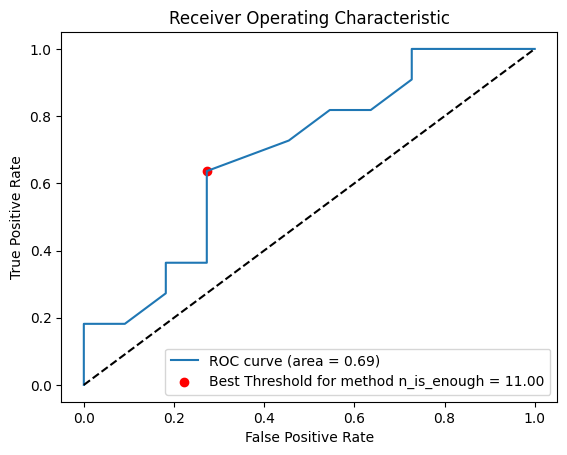

Area Under Curve: 0.6900826446280992
Best Threshold (closest to (0,1)): 11.0


In [325]:
val_roc_results_aggregate["2_5d_n"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

<center>

#### Validation ROC General Comparison

</center>

In [337]:
mean_compare = {k: v for k, v in val_roc_results_aggregate.items() if "mean" in k}
n_compare = {k: v for k, v in val_roc_results_aggregate.items() if "_n" in k}
ratio_compare = {k: v for k, v in val_roc_results_aggregate.items() if "ratio" in k}

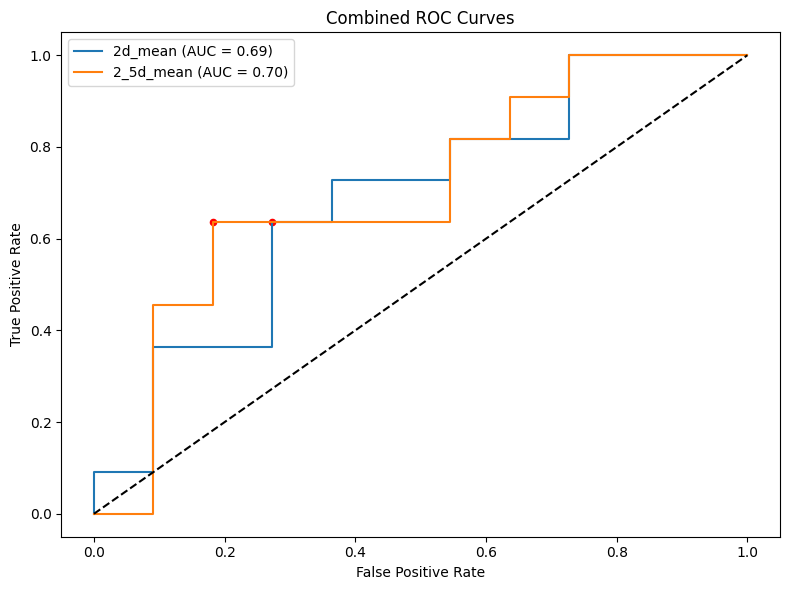

In [338]:
plotCombinedRoc(mean_compare)

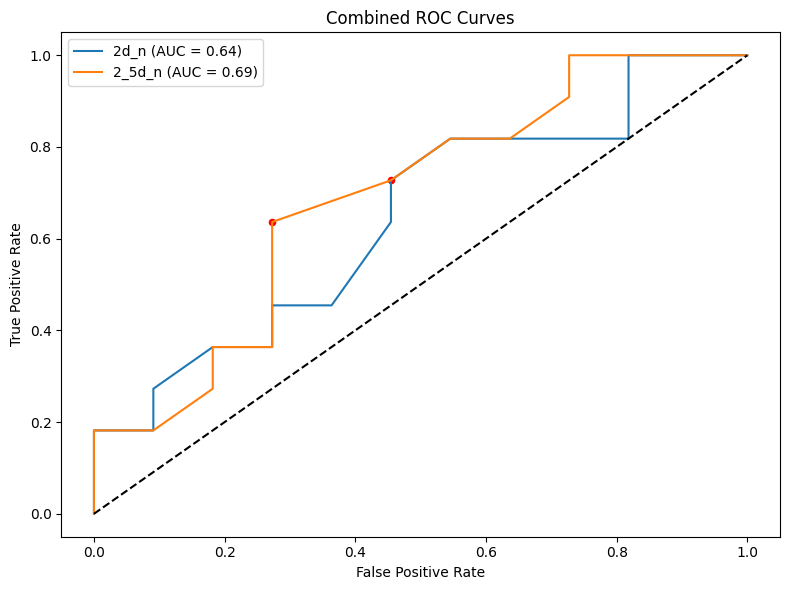

In [339]:
plotCombinedRoc(n_compare)

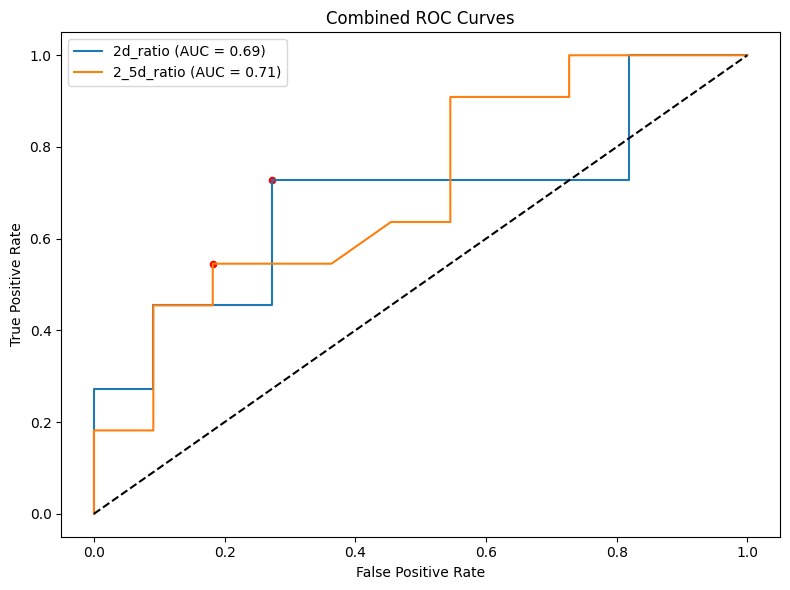

In [340]:
plotCombinedRoc(ratio_compare)

In [341]:
# Structure is mean, n_is_enough and ratio
thresholds_eval = {}
thresholds_eval["2_5d"] = [val_roc_results_aggregate["2_5d_mean"]["best_threshold"],
                             val_roc_results_aggregate["2_5d_n"]["best_threshold"],
                               val_roc_results_aggregate["2_5d_ratio"]["best_threshold"],]


<a name="24-comparison-with-2d"></a>
### 2.4 Comparison with 2D  


In [ ]:
metrics_mean = {}
metrics_n = {}
metrics_ratio = {}

#### Mean

In [358]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=thresholds_eval[key][0])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=thresholds_patient[key][0])
    metrics_mean[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 71.43%  (10 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 70.60%

 --------------------- 

F1 Score (Macro): 0.704
F1 Score (Weighted): 0.710
F1 Score Class 0: 0.667
F1 Score Class 1: 0.741

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 4 10]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 71.43%  (10 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 70.60%

 --------------------- 

F1 Score (Macr

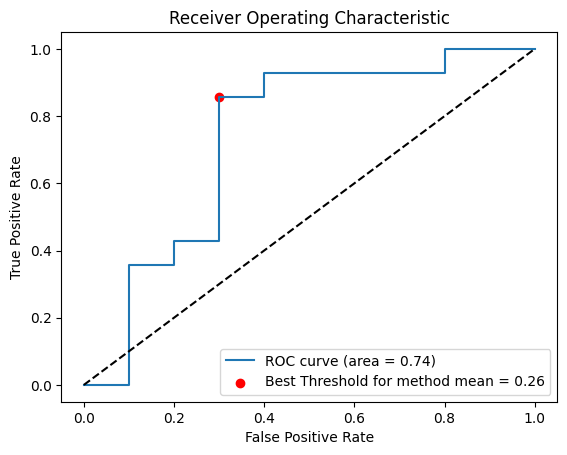

Area Under Curve: 0.7357142857142858
Best Threshold (closest to (0,1)): 0.25978996273544097


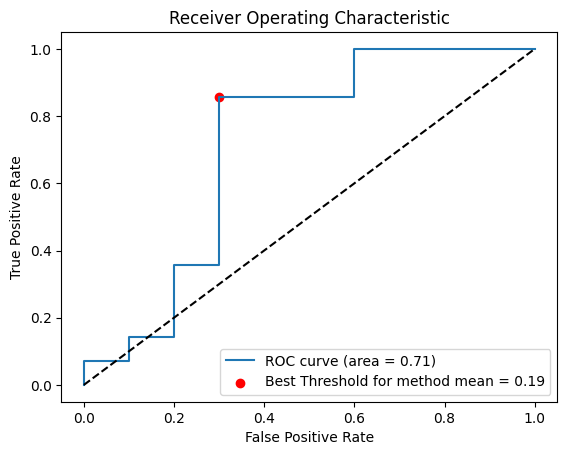

Area Under Curve: 0.7142857142857142
Best Threshold (closest to (0,1)): 0.18966695383704943


In [361]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_mean"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="mean")

test_roc_results_aggregate["2_5d_mean"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="mean", method="2_5d_")

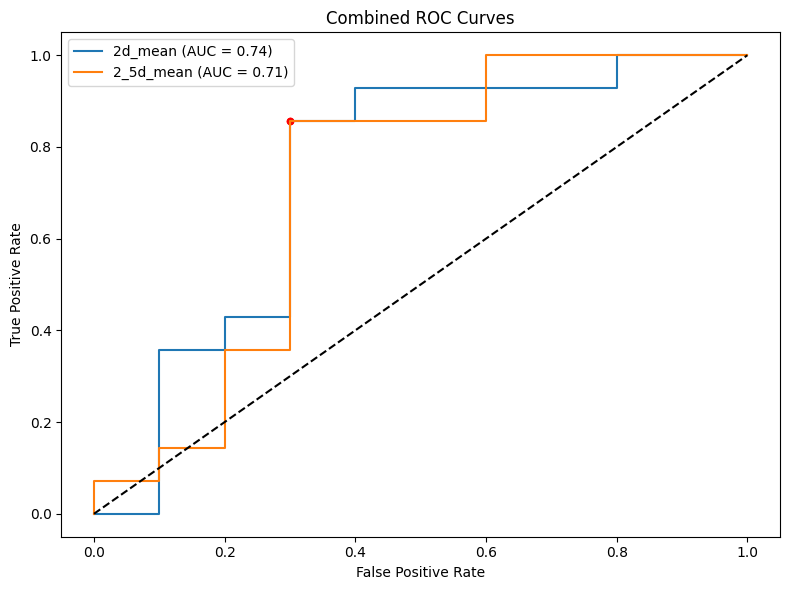

In [362]:
plotCombinedRoc(test_roc_results_aggregate)

#### Absolute Value Tests 

In [372]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"], aggregate_criteria="n_is_enough",
                                          n=thresholds_eval[key][1])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=THRESHOLD_EVAL, aggregate_criteria="n_is_enough",
                                          n=thresholds_patient[key][1])
    metrics_n[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 79.17%
Weighted Accuracy: 76.55%

 --------------------- 

F1 Score (Macro): 0.782
F1 Score (Weighted): 0.790
F1 Score Class 0: 0.737
F1 Score Class 1: 0.828

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 2 12]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 60.00%  (6 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 75.00%
Weighted Accuracy: 70.71%

 --------------------- 

F1 Score (Macr

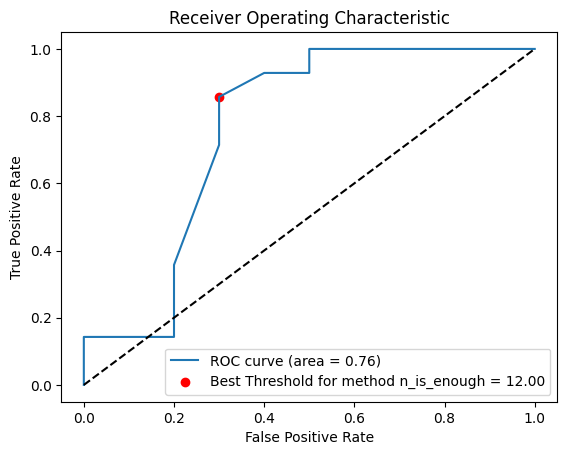

Area Under Curve: 0.7642857142857142
Best Threshold (closest to (0,1)): 12.0


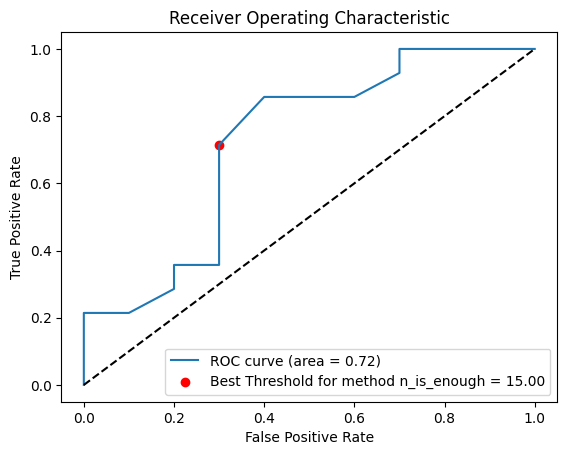

Area Under Curve: 0.7214285714285713
Best Threshold (closest to (0,1)): 15.0


In [373]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_n"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

test_roc_results_aggregate["2_5d_n"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="n_is_enough", method="2_5d_")

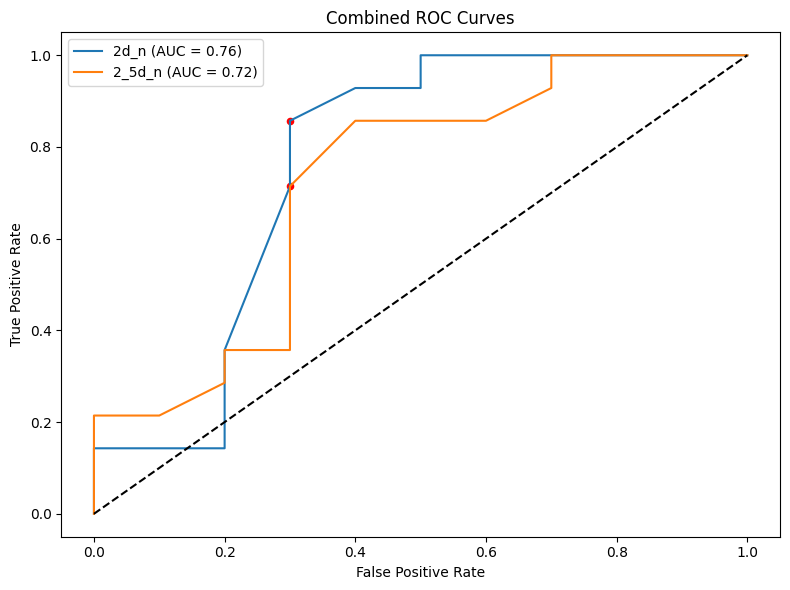

In [374]:
plotCombinedRoc(test_roc_results_aggregate)

#### Relative Value Tests

In [375]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"], aggregate_criteria="ratio",
                                          ratio=thresholds_eval[key][2])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=THRESHOLD_EVAL, aggregate_criteria="ratio",
                                          ratio=thresholds_patient[key][2])
    metrics_ratio[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 79.17%
Weighted Accuracy: 76.55%

 --------------------- 

F1 Score (Macro): 0.782
F1 Score (Weighted): 0.790
F1 Score Class 0: 0.737
F1 Score Class 1: 0.828

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 2 12]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 60.00%  (6 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 75.00%
Weighted Accuracy: 70.71%

 --------------------- 

F1 Score (Macr

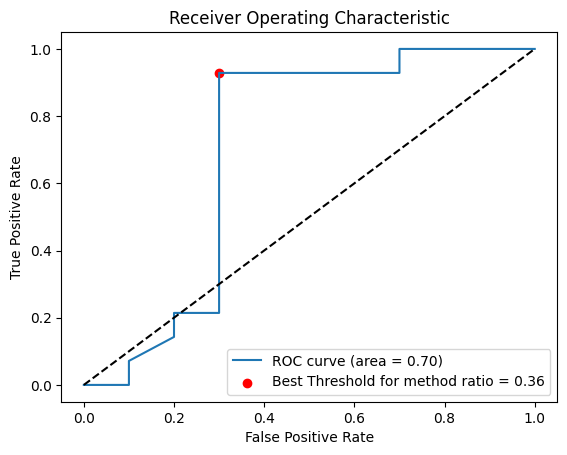

Area Under Curve: 0.7035714285714285
Best Threshold (closest to (0,1)): 0.36363636363636365


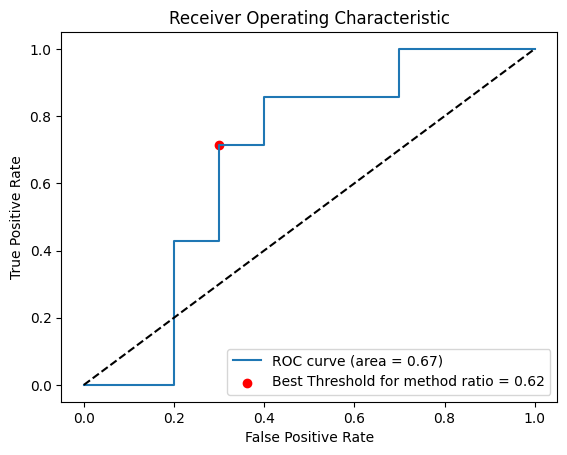

Area Under Curve: 0.6714285714285714
Best Threshold (closest to (0,1)): 0.6190476190476191


In [376]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_ratio"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="ratio")

test_roc_results_aggregate["2_5d_ratio"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="ratio", method="2_5d_")

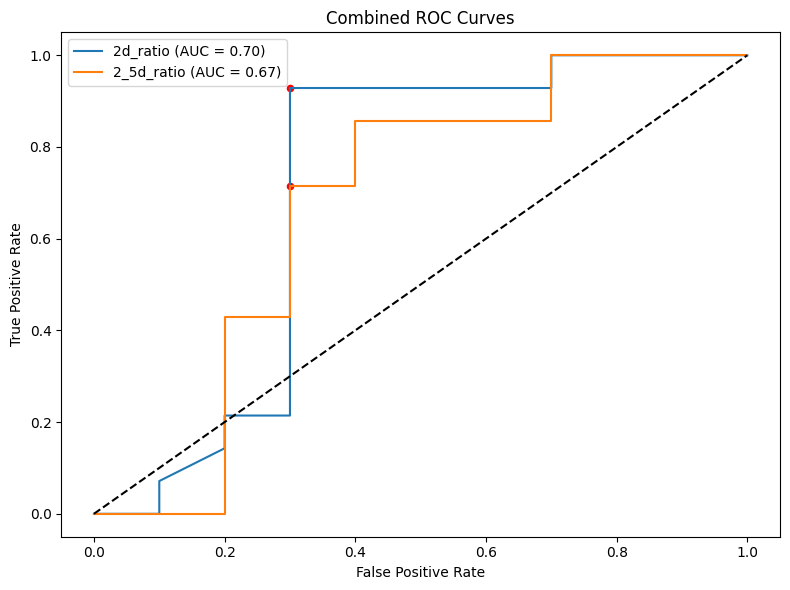

In [377]:
plotCombinedRoc(test_roc_results_aggregate)

---

<a name="3-slice-level-feature-wise-classification"></a>
## 3. Slice-level Feature-wise Classification




<a name="31-concept-overview"></a>
### 3.1 Concept Overview  

For detailed information on feature extraction and visualization methods, please refer to directory `4.3 - featureExtraction`.



<a name="33-25d-execution-of-slice-level-feature-wise-classification"></a>
### 3.2 Slice-level Feature-wise Classification  


In [381]:
results_ftrs = {}

<center> 

#### <span style="color:#2377c4"> 2D Feature Extraction </span>

</center>

Not needed, results will be copied to avoid previous hassles.

<center> 

#### <span style="color:orange"> 2.5D Feature Extraction </span>

</center>

In [50]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            
            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        
                
        return image, label, patient_id

In [51]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform) #, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 1170: 66__CT-9620-0014.npy
(224, 224, 3)


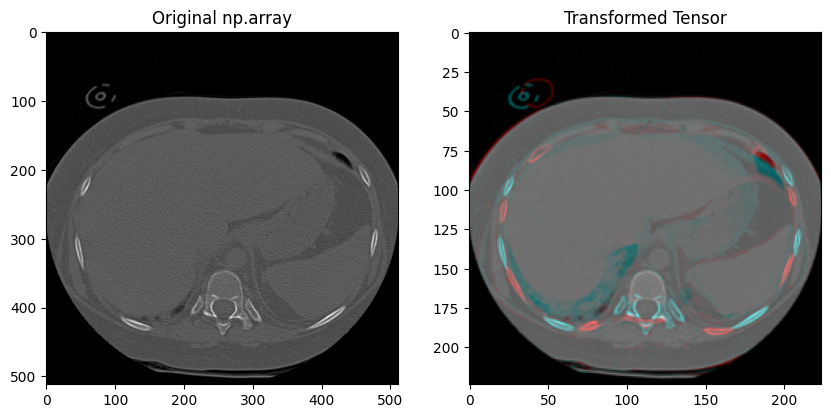

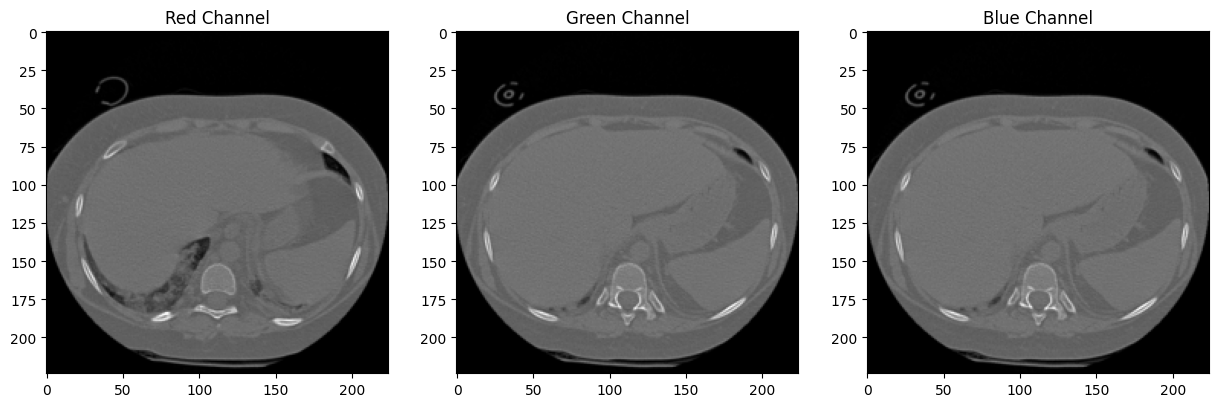

In [52]:
tensorVSnp(train_dataset, df_fibrosis)

In [42]:
features, labels, test_features, test_labels = getFeatures(resnet_eval, train_dataset, val_dataset, test_dataset)

Populating test features...: 100%|██████████| 21/21 [00:03<00:00,  6.30it/s]


In [43]:
print(len(features), "slices of shape",(features[0]).shape,"for training + validation")
print(len(test_features),"slices of shape", test_features[0].shape, "for test")

2427 slices of shape torch.Size([512, 1, 1]) for training + validation
648 slices of shape torch.Size([512, 1, 1]) for test


In [44]:
features_reshaped, test_reshaped = [], []

# Each ftr is now (512,)
[features_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in features] 
[test_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in test_features] 

# For visualization purposes
print('--------------------------------------------------------------')
print("Number of slices with derived features: ", len(features_reshaped))
print("Number of total train + validation slices: ", len(train_dataset) + len(val_dataset))
print("Slice features shape: ",features_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", features_reshaped[0][:5])
print('--------------------------------------------------------------')
print("Number of test slices with derived features: ", len(test_reshaped))
print("Number of total test slices: ", len(test_dataset))
print("Slice features shape: ",test_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", test_reshaped[0][:5])
print('--------------------------------------------------------------')

--------------------------------------------------------------
Number of slices with derived features:  2427
Number of total train + validation slices:  2427
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([0.9595, 0.1018, 0.4058, 1.3112, 1.3767])
--------------------------------------------------------------
Number of test slices with derived features:  648
Number of total test slices:  648
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([1.2729, 0.0706, 0.0138, 1.9882, 1.1652])
--------------------------------------------------------------


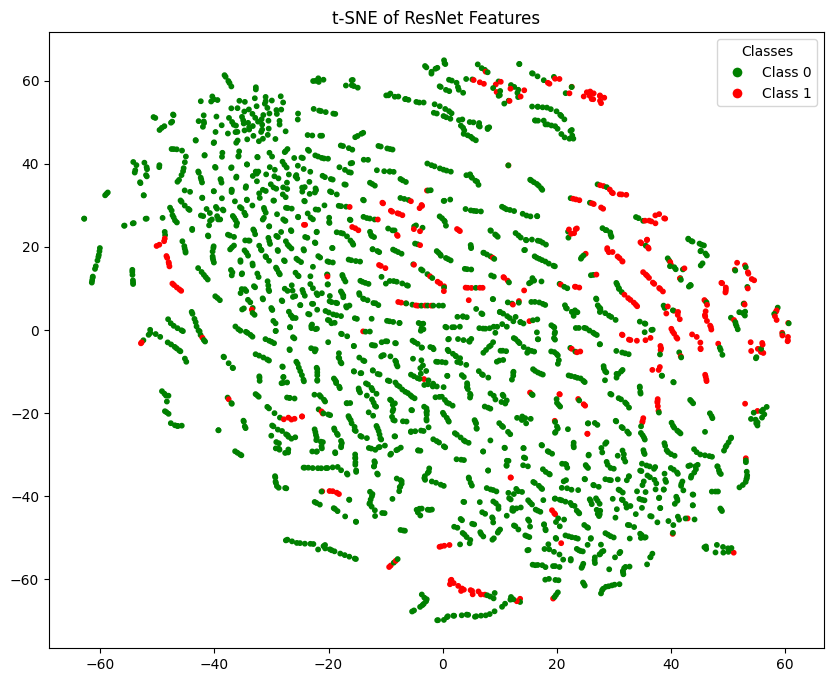

In [45]:
plotTSNE(features_reshaped, labels)

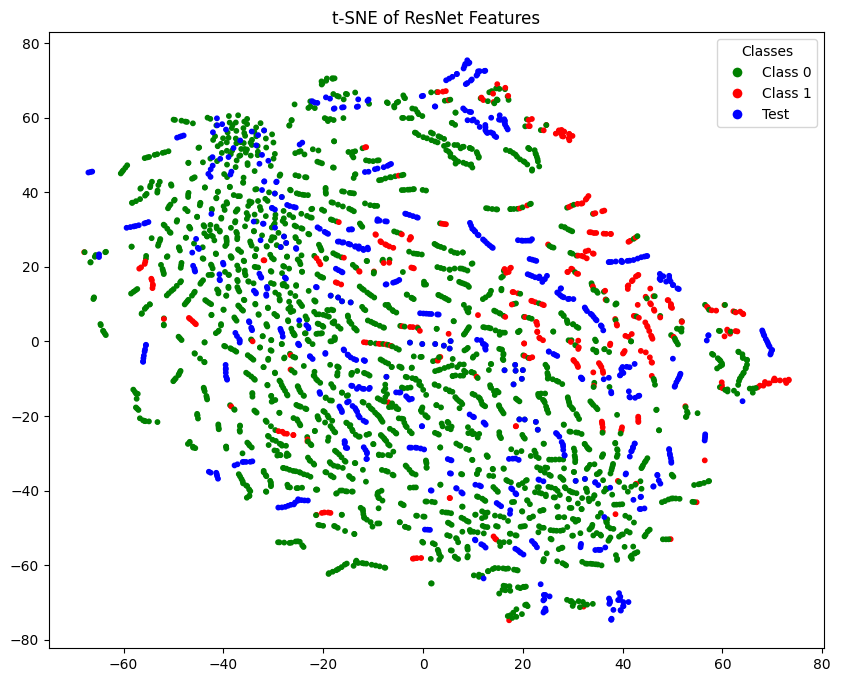

In [46]:
plotTSNE(features_reshaped, labels, test_features)

#### EXTRAS: Manifestation Plots

In [47]:
# Setup
root = r"..\\..\\..\\fibrosis_dataset\ILD_DB_txtROIs"
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

train_ds = pd.read_csv(annotations_file_train)
val_ds = pd.read_csv(annotations_file_val)

manifest_dict = searchDiffManifest(root,verbose=0)

full_df = pd.concat([train_ds, val_ds], ignore_index=True)

manifest_df = manifestationDataframe(manifest_dict, full_df)

⚠️ Warning: Folder '108' not found in datasets.
⚠️ Warning: Folder '150' not found in datasets.
⚠️ Warning: Folder '155' not found in datasets.
⚠️ Warning: Folder '157' not found in datasets.
⚠️ Warning: Folder '12' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8871' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8873' not found in datasets.


107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!
121__CT-0844-0010.npy is not class 1!!!


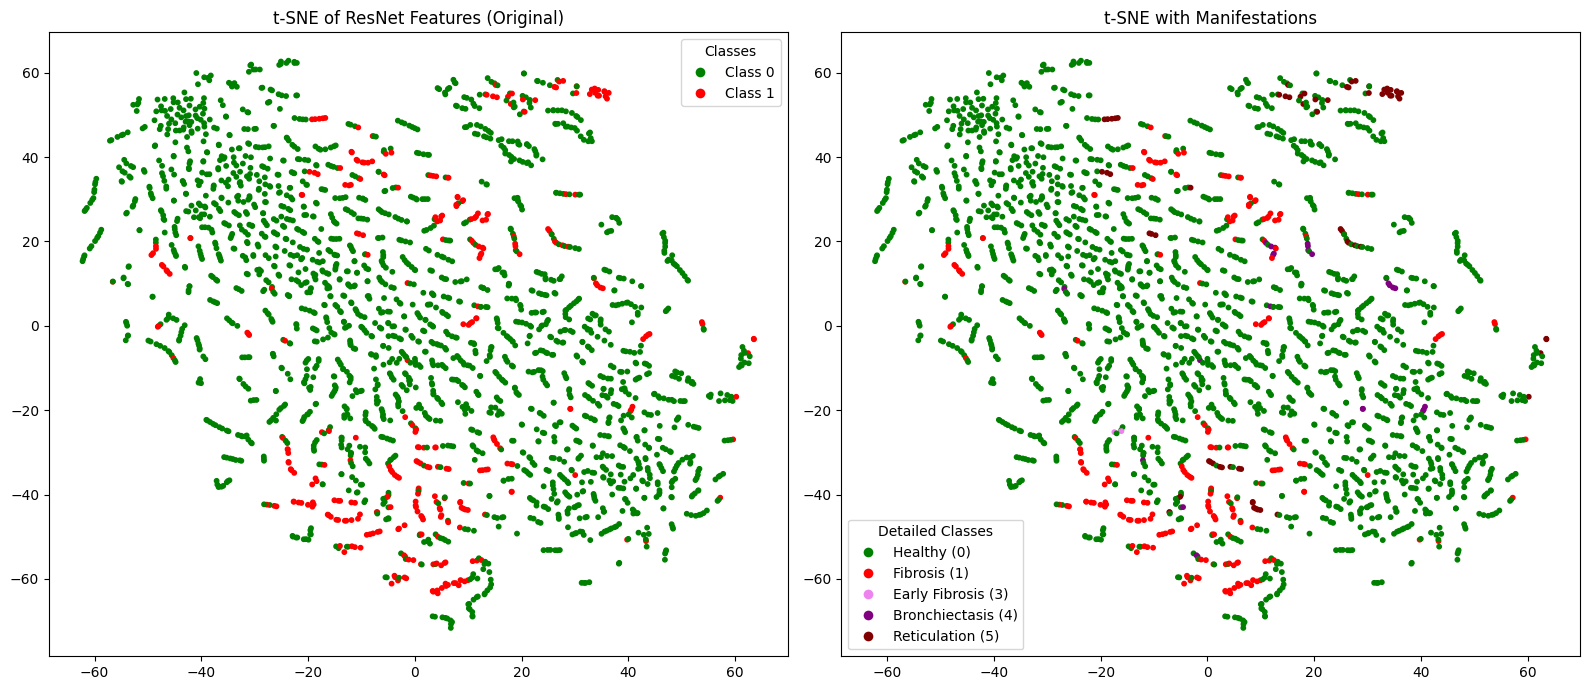

In [48]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False)

107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!
121__CT-0844-0010.npy is not class 1!!!


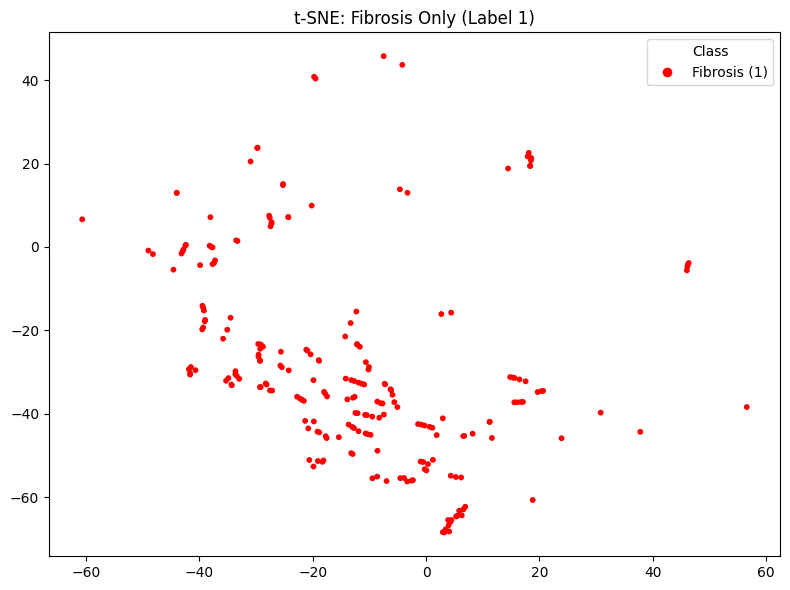

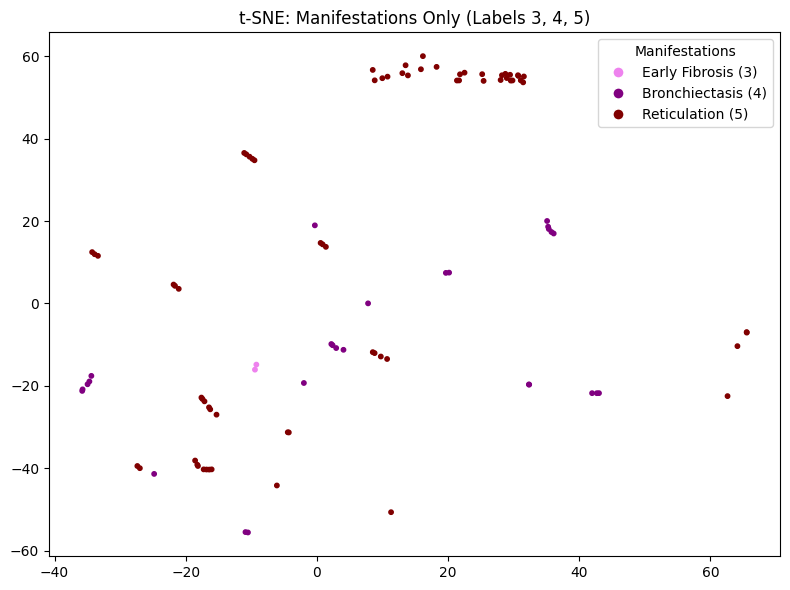

: 

In [ ]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False, mask=True)




<a name="32-threshold-selection-and-model-choice"></a>
### 3.3 Threshold Selection and Model Choice  




Testing for best k...: 100%|██████████| 512/512 [04:40<00:00,  1.82it/s]


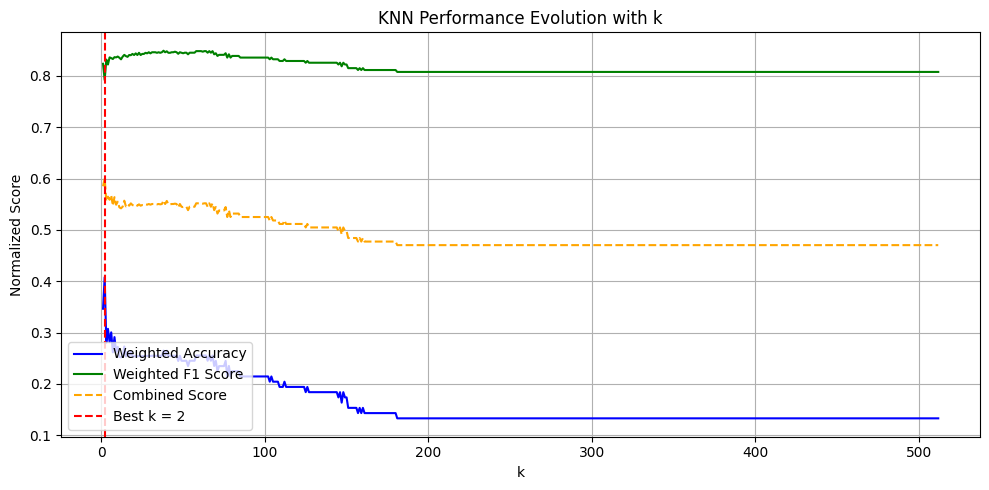

In [41]:
k_list_euclid, w_acc_list_euclid, w_f1_list_euclid = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=i,verbose=0)
    k_list_euclid.append(k_i)
    w_acc_list_euclid.append(weighted_acc_i)
    w_f1_list_euclid.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_euclid, w_acc_list_euclid, w_f1_list_euclid)

Testing for best k...: 100%|██████████| 512/512 [04:38<00:00,  1.84it/s]


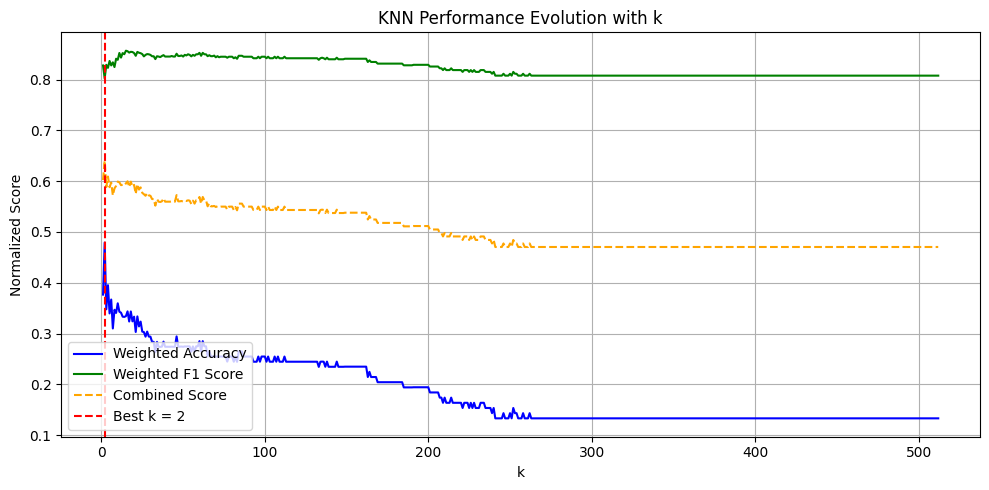

In [43]:
k_list_cosine, w_acc_list_cosine, w_f1_list_cosine = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels, criteria="cosine",k=i,verbose=0)
    k_list_cosine.append(k_i)
    w_acc_list_cosine.append(weighted_acc_i)
    w_f1_list_cosine.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_cosine, w_acc_list_cosine, w_f1_list_cosine)


<a name="34-comparison-with-2d"></a>
### 3.4 Comparison with 2D  


In [379]:
metrics_euclid = {}
metrics_cosine = {}
metrics_mahal = {}

#### Euclidean Performance

In [357]:
print("                            Eucliean Distance Performance for k=2                            ")
m_euclid = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=2)

                            Eucliean Distance Performance for k=2                            

 --------------------- 

Accuracy for Class 0: 81.88%  (461 in 563)
Accuracy for Class 1: 35.29%  (30 in 85)
Test Accuracy: 75.77%
Weighted Accuracy: 41.49%

 --------------------- 

F1 Score (Macro): 0.565
F1 Score (Weighted): 0.779
F1 Score Class 0: 0.854
F1 Score Class 1: 0.276

 --------------------- 


Confusion Matrix: 
 [[461 102]
 [ 55  30]]


#### Cosine Performance

In [358]:
print("                            Cosine Distance Performance for k=8                            ")
m_cosine = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="cosine",k=2)

                            Cosine Distance Performance for k=8                            

 --------------------- 

Accuracy for Class 0: 81.35%  (458 in 563)
Accuracy for Class 1: 43.53%  (37 in 85)
Test Accuracy: 76.39%
Weighted Accuracy: 48.56%

 --------------------- 

F1 Score (Macro): 0.591
F1 Score (Weighted): 0.787
F1 Score Class 0: 0.857
F1 Score Class 1: 0.326

 --------------------- 


Confusion Matrix: 
 [[458 105]
 [ 48  37]]


#### Mahalanobis Performance

In [369]:
m_mahal = featuresKNN_CPU(features_reshaped, labels, test_reshaped, test_labels,criteria="mahalanobis")

Length of class1: 324


Computing mahalanobis distances... : 100%|██████████| 648/648 [01:15<00:00,  8.62it/s]

Total examples: 648

 --------------------- 

Accuracy for Class 0: 98.40%  (554 in 563)
Accuracy for Class 1: 16.47%  (14 in 85)
Test Accuracy: 87.65%
Weighted Accuracy: 27.37%

 --------------------- 

F1 Score (Macro): 0.596
F1 Score (Weighted): 0.844
F1 Score Class 0: 0.933
F1 Score Class 1: 0.259

 --------------------- 


Confusion Matrix: 
 [[554   9]
 [ 71  14]]


In [380]:
metrics_euclid["2d"] = [0.8472, 0.5176, 0.8040, 0.5615,
                        0.646, 0.820, 0.883, 0.409, None]

metrics_cosine["2d"] = [0.8526, 0.6000, 0.8194, 0.6336,
                         0.679, 0.836, 0.891, 0.466, None]

metrics_mahal["2d"] = [0.8615, 0.5294, 0.8179, 0.5736,
                        0.662, 0.831, 0.892, 0.433, None]

In [381]:
metrics_euclid["2_5d"] = m_euclid
metrics_cosine["2_5d"] = m_cosine
metrics_mahal["2_5d"] = m_mahal

---

<a name="4-conclusion"></a>

## 4. Conclusion 


### 4.1 Methodology for Plots

The metrics dictionaries follow the structure below:

```py

metrics_topic[method] = [accuracy_class_0, accuracy_class_1, accuracy, weighted_accuracy,
                         f1_macro, f1_weighted, f1_class_0, f1_class_1, conf_mat] 

```

For simplicity of result analysis, I decided to create side-by-side barplots for 2D vs 2.5D:

In [367]:
# Auxiliary function, helps creating 2 barplots in 1 plot
def plotGroup(group_dict, title, subplot_index, metric_labels):
    methods = list(group_dict.keys())
    values = [group_dict[m][:8] for m in methods]  # Exclude conf_mat
    num_metrics = len(metric_labels)
    x = np.arange(num_metrics)

    width = 0.8 / len(methods)  # Dynamic bar width

    plt.subplot(2, 1, subplot_index)
    for i, (method, vals) in enumerate(zip(methods, values)):
        # Choose color based on method name
        #color = 'red' if '_5' in method else '#2377c4'
        plt.bar(x + i * width, vals, width=width, label=method) #, color=color)

    plt.xticks(x + width * (len(methods) - 1) / 2, metric_labels, rotation=45)
    plt.ylabel("Score")
    plt.title(title, fontsize=14, pad=20)  # Increase font size and space below title
    plt.legend()
    plt.tight_layout(pad=8.0)  # Adjust spacing between subplots

    

def barPlotCollection(metrics_dict, title2, title1=None):
    # Define metric labels (excluding conf_mat for plotting)
    metric_labels = [
        "Class 0 \nAccuracy", "Class 1 \nAccuracy", "Accuracy", "Weighted \nAccuracy",
        "F1 Macro", "F1 Weighted", "F1 Class 0", "F1 Class 1"
    ]
    
    #if len(metrics_dict.keys()) > 2:
    # Split methods into 'no' and 'others'
    methods_with_no = {k: v for k, v in metrics_dict.items() if "no" in k.lower()}
    methods_others = {k: v for k, v in metrics_dict.items() if "no" not in k.lower()}
    
    
    plt.figure(figsize=(12, 10))

    if methods_with_no:
        plotGroup(
            methods_with_no,
            title1,
            1,
            metric_labels
        )

    if methods_others:
        plotGroup(
            methods_others,
            title2,
            2 if methods_with_no else 1,
            metric_labels
        )    


        plt.tight_layout()
        plt.show()

<center> 

### Augmentations

</center>

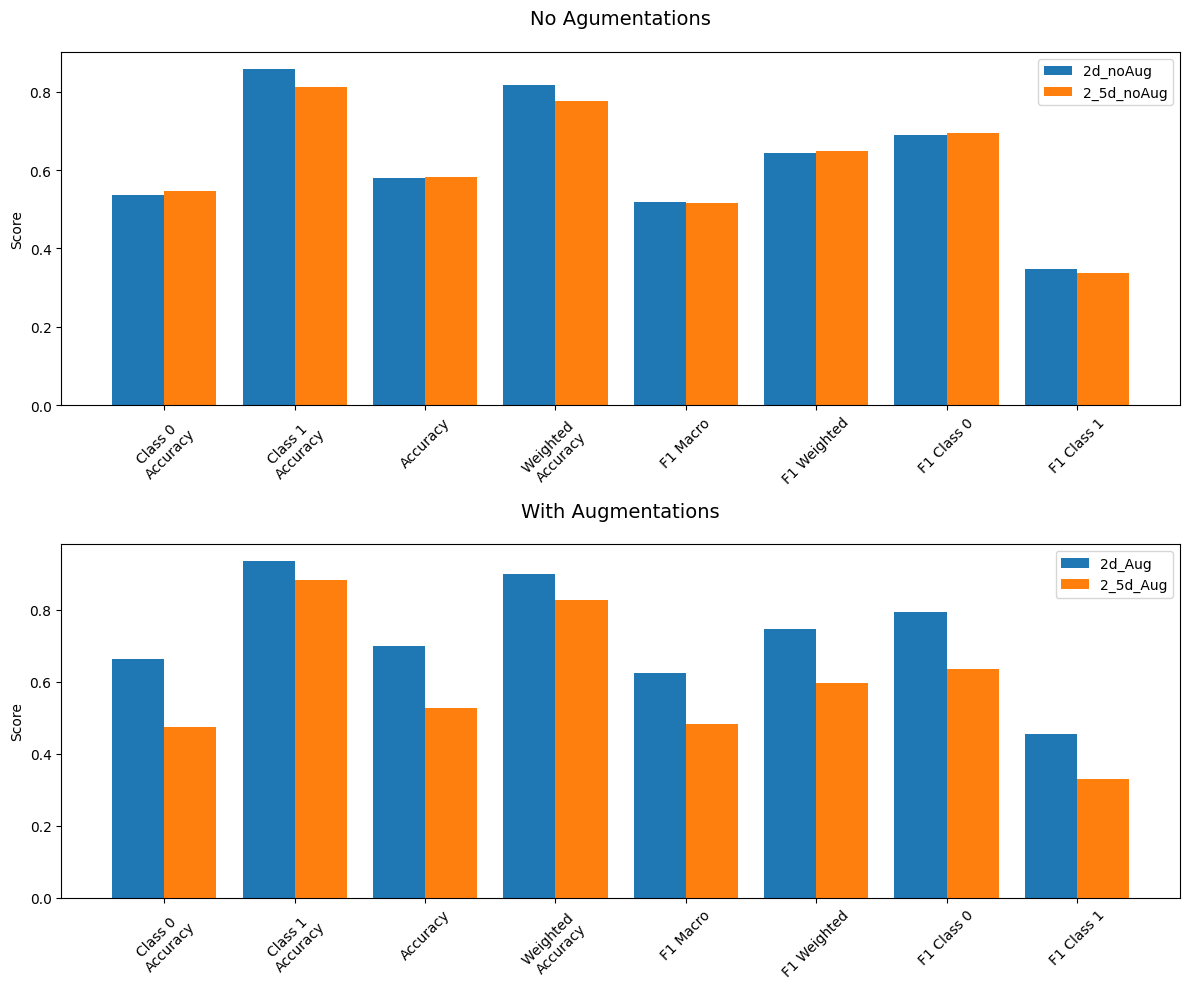

In [368]:
barPlotCollection(metrics_aug, "With Augmentations", "No Agumentations",)

<center> 

### Patient Aggregation: Mean

</center>

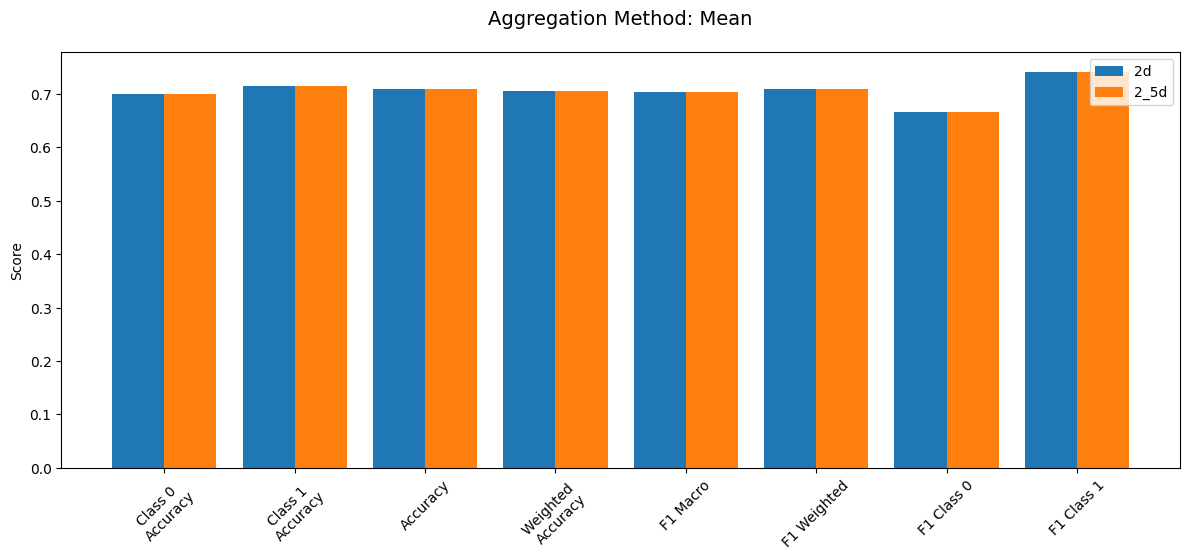

In [378]:
barPlotCollection(metrics_mean, "Aggregation Method: Mean")

<center> 

### Patient Aggregation: N_is_enough

</center>

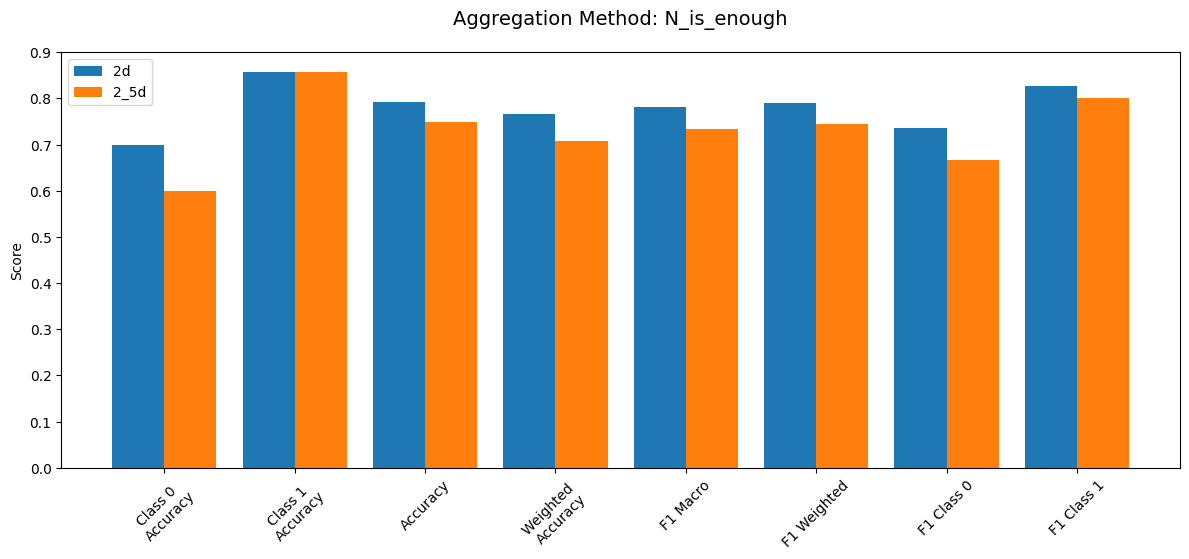

In [379]:
barPlotCollection(metrics_n, "Aggregation Method: N_is_enough")

<center> 

### Patient Aggregation: Ratio

</center>

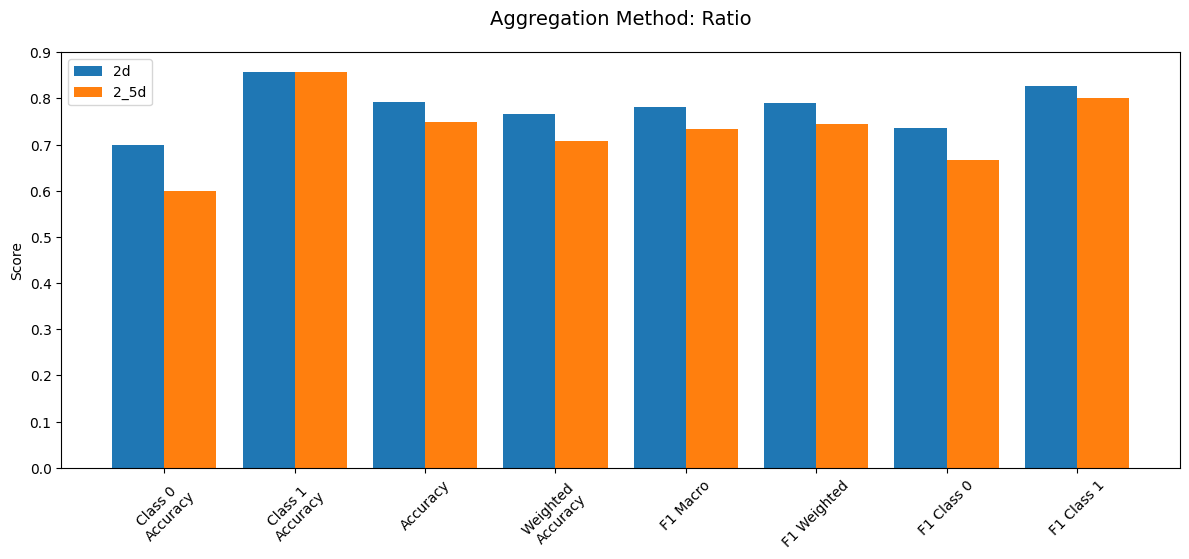

In [380]:
barPlotCollection(metrics_ratio, "Aggregation Method: Ratio")

<center> 

### Feature Extraction: Euclidean

</center>

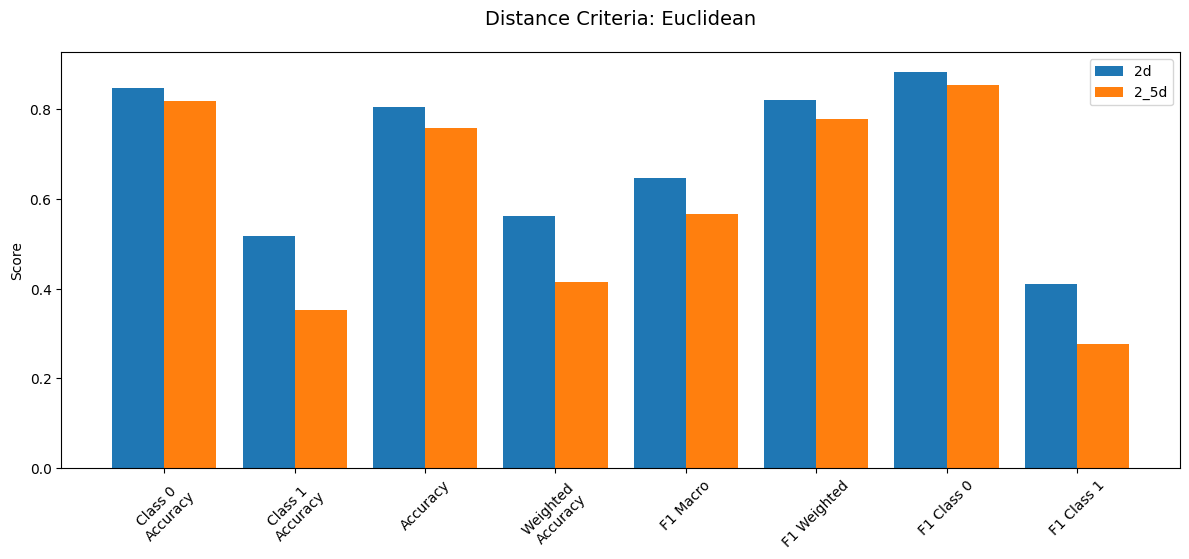

In [403]:
barPlotCollection(metrics_euclid, "Distance Criteria: Euclidean")

<center> 

### Feature Extraction: Cosine

</center>

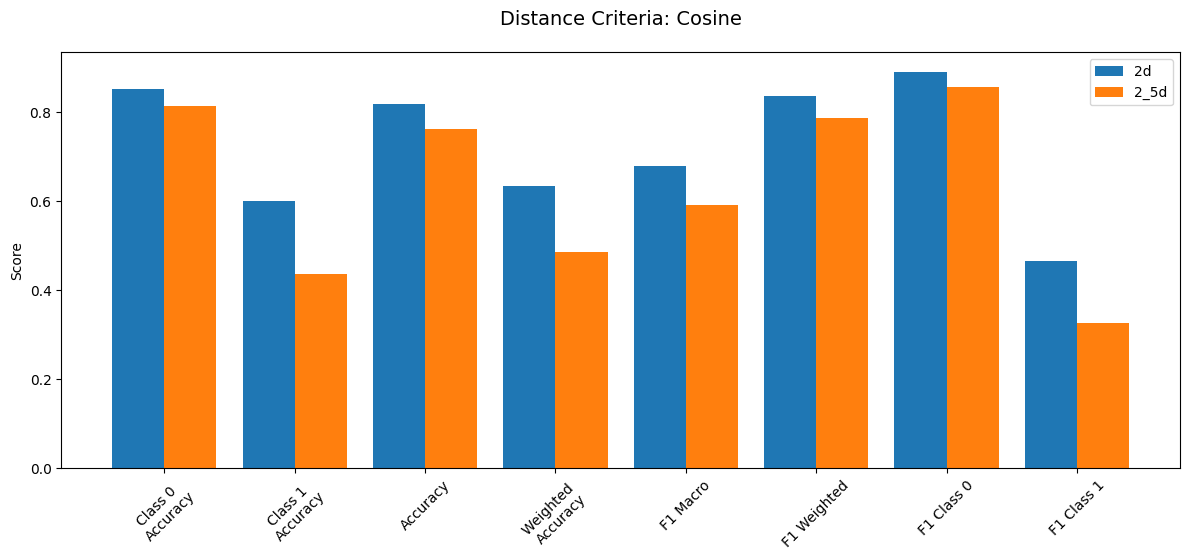

In [404]:
barPlotCollection(metrics_cosine, "Distance Criteria: Cosine")

<center> 

### Feature Extraction: Mahalanobis

</center>

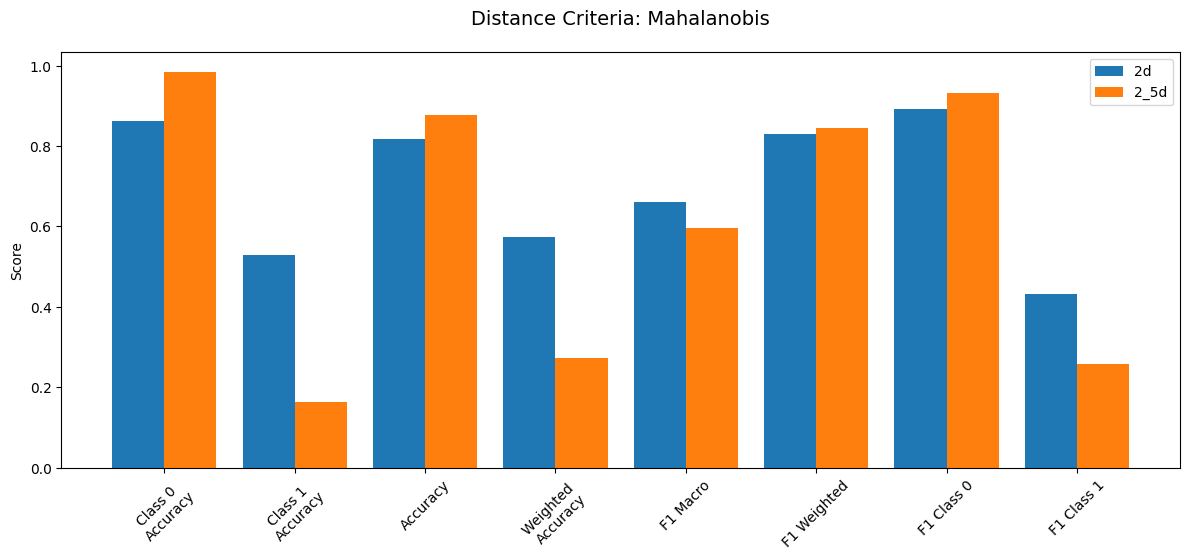

In [405]:
barPlotCollection(metrics_mahal, "Distance Criteria: Mahalanobis")